TODO:

Improve, and justify MLP as the Baseline (3 layers)

CNN is the advanced model; must make CNN from scratch e.g. like program each layer

Hyperparameter tune the batch, try Bayesian Search as it is not bruteforce, and does hyperparameter tuning. 

design cnn better now

take images for test

try leakyrelu

softmax all the layers, etc. 

apply L1 + L2 regularization to CNN

dropouts

reduce input size

try Bayes Search CV instead of grid - probabalistic model so less computationally expensive

Show a table for final judgement.

Add some filtering methods

Add wrapper based methods for ensemble

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 48px;"><strong>Assignment 2:</strong></h1>
    <h2 style="color:#7D3C98;">Machine Learning Project</h2>
    <h2 style="color:#7D3C98;"><strong>COSC2673</strong> Machine Learning</h2>
    <h3 style="color:#D2B4DE; margin-top: 20px;">(Undergraduate Level)</h3>
    <h3 style="background: linear-gradient(to right, #7D3C98, #D7BDE2); -webkit-background-clip: text; color: solid;">By Oisin Aeonn & Vince Quach</em></h3>
    <h4 style="color:#BB8FCE;">Student IDs: s3952320 & s3900481</h4>
</div>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">1.0 Table of Contents</h3>
    <h3 style="color:#D2B4DE; margin-top: 20px;">1.1 Read Me</h3>
    <h3 style="color:#D2B4DE; margin-top: 20px;">1.2 Introduction</h3>
    <h3 style="color:#D2B4DE; margin-top: 20px;">1.3 Python Library Imports</h3>
    <h3 style="color:#D2B4DE; margin-top: 20px;">2.0 Exploratory Data Analysis (EDA)</h3>
    <h3 style="color:#D2B4DE; margin-top: 20px;">2.1 Data Ingestion</h3>
    <h3 style="color:#D2B4DE; margin-top: 20px;">2.2 Data Splitting</h3>
    <h4 style="color:#D2B4DE; margin-top: 20px;">2.2-1 Checking for Data Leaks</h4>
    <h3 style="color:#D2B4DE; margin-top: 20px;">3.0 Using Supervised Non-Neural Network Models (Regression, Tree-Based, & Gradient Boosting)</h3>
    <h3 style="color:#D2B4DE; margin-top: 20px;">4.0 Baseline Multi-Layer-Perceptron Model</h3>
    <h3 style="color:#D2B4DE; margin-top: 20px;">5.0 Advanced Modelling using Convolutional Neural Networks</h3>
    <h3 style="color:#D2B4DE; margin-top: 20px;">6.0 Independent Evaluation and Test</h3>
    <h3 style="color:#D2B4DE; margin-top: 20px;">6.0 Extending the Convolutional Neural Networks</h3>
    <h6 style="color:#D2B4DE; margin-top: 20px;">NOTE: Complementary Sections are denoted with *</h6>
</div>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">1.1 Read Me</h1>

<ul style="color:#7D3C98;">
    <li>All tasks were completed in accordance with the Assignment 2 Brief.</li><br>
    <li>The Discussion Forum, Tutorials, and Lectures were all utilised effectively to get as best as an understanding of the assignment requirements as possible, however there was some ambiguity, and freedom in the way things were phrased, so we tried to have as much fun, and treat this as a real-world problem that would have implications if we got things wrong.</li><br> 
    <li>A few sections are marked as Complementary (denoted with *), or use methods not allowed, or required in the Assessment. These were covered for fun, to further improve our models, and for our own personal learning.</li><br>
    <li>Predictions are dynamically generated within this Jupyter Notebook, some cells are optional, and running them lead to different results. Generally run all cells to see expected results.</li><br>
    <li>This project was completed in alignment with RMIT University's Academic Integrity Policy and was solely undertaken by Oisin Aeonn (s3952320) & Vince Quach (s3900481) within the specified timeframe. All materials used are cited, and referenced accordingly.</li><br>
    <li>The project was submitted on-time to the COSC2673 (Undergraduate) Machine Learning Canvas before Wednesday 11:59PM May 15, 2024.</li><br>
    <li>Our video can be found here: X going through our presentation of this Jupyter Notebook, Report, and corresponding materials.</li><br>
    <li>We are deeply passionate about Machine Learning and aspire to build a career in this field. We are eager for any constructive feedback to enhance our learning and application.</li><br>
    <li>Special thanks to Dr Azadeh Alavi, Dr Pubudu Sanjeevani, and Ms. Rumin Chu for their invaluable assistance and support in our learning journey.</li><br>
    <li>I hope you enjoy our work!</li><br>
</ul>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">1.2 Introduction</h1>

<h5 style="color:#D2B4DE; margin-top: 20px;">
    <ul>
        <li><b>Problem Statement:</b>
            <ul>
                <br><li>We selected 'Project 1: Classify Images of Road Traffic Signs' for our Assessment 2. This Project's goal is to develop an n-ary Classification Model for RoadSigns using a modified version of the BelgiumTS dataset, where we will be focusing on creating a generalizable model that can work on an Independently sourced Evaluation Dataset. In order to achieve this goal we had to understand our training data through conducting the following tasks in order: 
                    Extensive EDA, 
                    Ingest our data, 
                    Prepare it for training by assigning labels to the dataset, 
                    Splitting the data into Training, & Validation, 
                    And then finally training, and evaluating the model performance using Evaluation Metrics.</li>
                <br><li>We will first start by exploring some simple, and less computational intensive techniques such as using the Sigmoid Activation Function in a Logistic Regression Model, and Tree-based Algorithms. Finally settling with a baseline model using a Multi-Layer Perceptron, utilizing subsequent optimizations found in Convolutional Neural Networks will be pursued through advanced machine learning techniques.</li>
            </ul>
        </li>
        <br><li><b>Dataset:</b>
            <ul>
                <br><li>The analysis is based on a modified version of the BelgiumTS dataset, encompassing various roadsigns in Belgium the country in Europe.</li>
            </ul>
        </li>
        <br><li><b>Objectives:</b>
            <ul>
                <br><li>Understand the fundamental concepts and algorithms of machine learning and applications.</li>
                <br><li>Understand a range of machine learning methods and the kinds of problem to which they are suited.</li>
                <br><li>Set up a machine learning configuration, including processing data and performing feature engineering, for a range of applications.</li>
                <br><li>Apply machine learning software and toolkits for diverse applications.</li>
                <br><li>Understand the ethical considerations involved in the application of machine learning.</li>
            </ul>
        </li>
        <br><li><b>Scope:</b>
            <ul>
                <br><li>Focus on predicting Life Expectancy leveraging methods and insights from weeks 1-4 of the COSC2673 Machine Learning Course.</li>
                <br><li>Adopt strategies such as regularization and normalization to refine the model, maintaining the integrity of the feature set.</li>
                <br><li>Strive for the optimal model performance within the established constraints.</li>
                <br><li>Undertake predictions on a separate, unseen dataset (<code>predictions.csv</code>) to validate the model's generalisability.</li>
            </ul>
        </li>
    </ul> 
</h5>


<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">1.3 Python Library Imports</h1>

<h5 style="color:#D2B4DE; margin-top: 20px;">
    <ul>
        <li>First, let's cover all of the required imports for this entire Jupyter Notebook.</li><br>
        <li>We put them all here so that you can run most cells (especially EDA, and TensorFlow) out of order.</li><br>
        <li>This also conforms to the coding standard DO NOT REPEAT YOURSELF (DRY).</li><br>
        <li>We also have provided a commented description of each library for their use.</li><br>
    </ul>
</h5>

In [4]:
# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# Tensorflow is a deep learning framework used for building and training neural networks.

# Numpy
import numpy as np
np.object = np.object_

# Numpy is a library for numerical computing in Python.

# Operating system interfaces
import os

# The os module provides a way to interact with the operating system.

# Data manipulation and analysis
import pandas as pd

# Pandas is a library for data manipulation and analysis.

# Model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

# Scikit-learn is a machine learning library that provides tools for model selection, evaluation, and preprocessing.

# Image processing
from PIL import Image
import imageio
from skimage import transform
from skimage.color import rgb2gray, gray2rgb

# These libraries provide functions for image processing, such as reading, writing, and transforming images.

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Matplotlib, Seaborn, and Plotly are libraries for data visualization and plotting.

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# This line ignores warnings to keep the output clean.

# Debug
print(os.environ['PATH'])
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

# These lines are used for debugging purposes, such as checking the system path and available GPUs.

# Plotting style
plt.style.use('dark_background')
%matplotlib inline

# These lines set the plotting style and enable inline plotting in Jupyter notebooks.

import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, measure
from scipy.spatial.distance import euclidean

/opt/anaconda/bin:/opt/anaconda/condabin:/usr/local/sbin:/usr/local/bin:/usr/bin:/var/lib/flatpak/exports/bin:/usr/lib/jvm/default/bin:/usr/bin/site_perl:/usr/bin/vendor_perl:/usr/bin/core_perl:/var/lib/snapd/snap/bin
Num GPUs Available:  0
[]


<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">2.0 Exploratory Data Analysis (EDA)</h1>

<h5 style="color:#D2B4DE; margin-top: 20px;">
<ul>
<li>Reason for performing EDA:
  <ul>
    <li>To gain insights into the characteristics and properties of the traffic sign images.</li>
    <li>To identify any patterns, trends, or anomalies in the dataset.</li>
    <li>To understand the distribution and variability of different features extracted from the images.</li>
    <li>To assess the quality and consistency of the image data.</li>
    <li>To inform further steps in the analysis or modeling process.</li>
  </ul>
</li>
<br>
<li>What we are looking for:
  <ul>
    <li>Image sizes and formats to ensure consistency and compatibility.</li>
    <li>Image sharpness to identify any blurry or low-quality images.</li>
    <li>Average pixel intensity to understand the overall brightness or darkness of the images.</li>
    <li>Image entropy to measure the amount of information or complexity in the images.</li>
    <li>Image similarities to identify duplicate or highly similar images.</li>
    <li>Domain-specific features (e.g., shape, color) relevant to traffic sign classification.</li>
  </ul>
</li>
</ul>
</h5>

In [2]:
# Directory containing the image dataset
dataset_path = 'trafficsigns_dataset'

# Function to get all image files in subdirectories
def get_image_files(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('.png')):
                image_files.append(os.path.join(root, file))
    return image_files

# Get the list of image files
image_files = get_image_files(dataset_path)

print("Number of image files found:", len(image_files))

# Initialize lists to store image properties
image_sizes = []
image_formats = []
image_sharpness = []
pixel_intensities = []
entropies = []
image_similarities = []
image_data = []

# Iterate over the image files
for image_path in image_files:
    try:
        image = io.imread(image_path, as_gray=True)
        
        # Get image size
        height, width = image.shape
        image_sizes.append((width, height))
        
        # Get image format
        image_format = os.path.splitext(image_path)[1][1:]
        image_formats.append(image_format)
        
        # Calculate image sharpness using the variance of the Laplacian
        sharpness = np.var(filters.laplace(image))
        image_sharpness.append(sharpness)
        
        # Calculate average pixel intensity
        pixel_intensity = np.mean(image)
        pixel_intensities.append(pixel_intensity)
        
        # Calculate image entropy
        entropy = measure.shannon_entropy(image)
        entropies.append(entropy)
        
        # Store image data for similarity calculation
        image_data.append(image.flatten())
        
        # Domain-specific analysis for road sign classification/shape
        # Example: Extract shape features using Hu moments
        moments = measure.moments_hu(image)
        # Perform further analysis or classification based on the extracted features
        
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")

# Calculate image similarities
for i, img1 in enumerate(image_data):
    if i == 0:
        image_similarities.append(0)
    else:
        distances = [euclidean(img1, img2) for img2 in image_data[:i]]
        image_similarities.append(np.min(distances))

Number of image files found: 3699


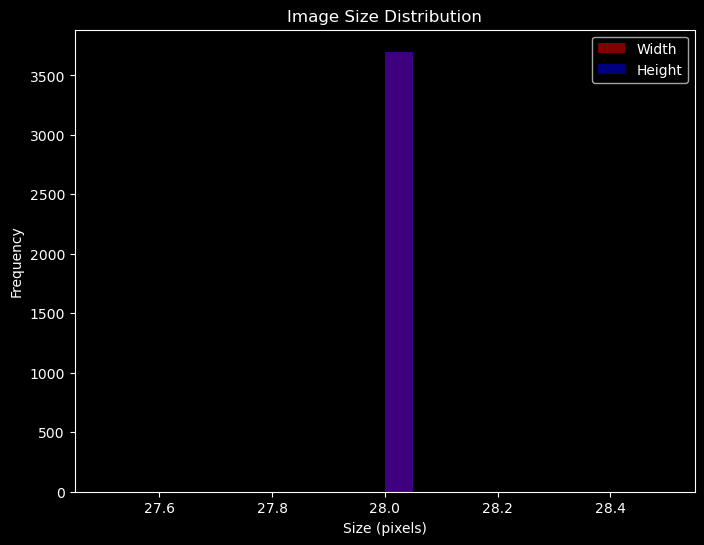

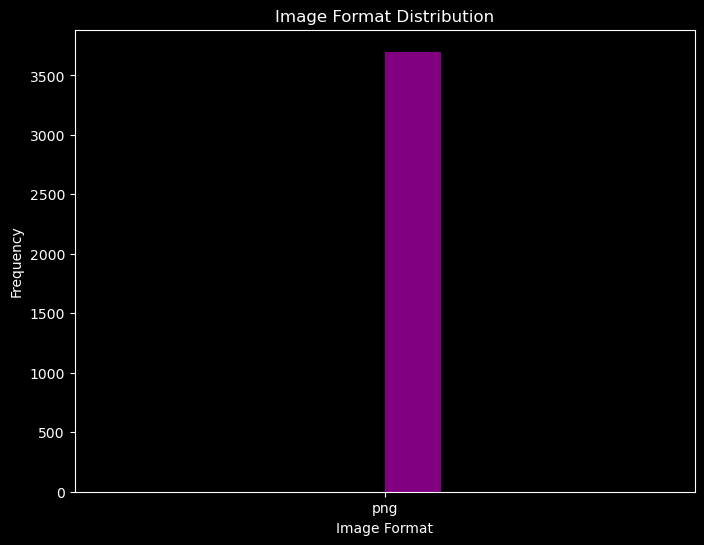

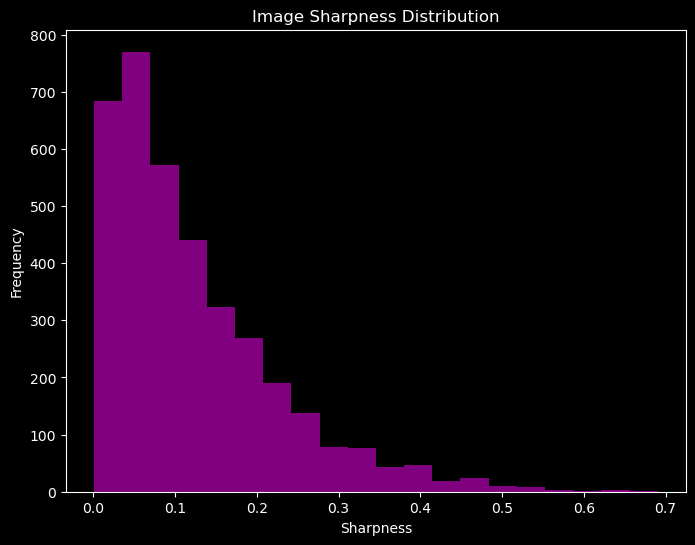

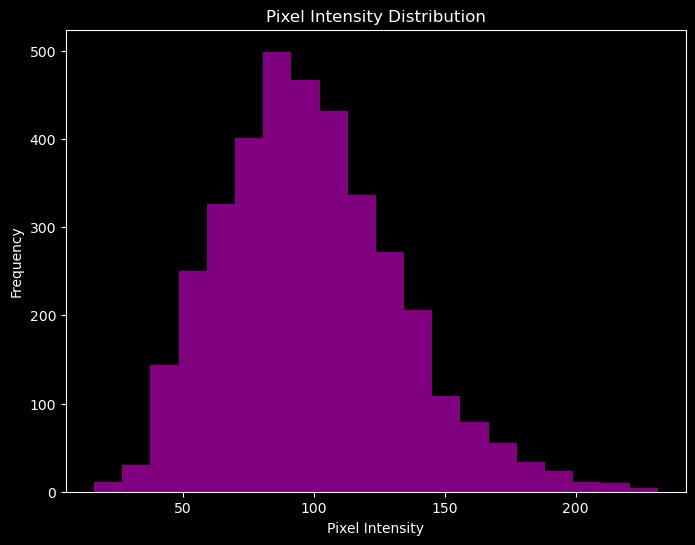

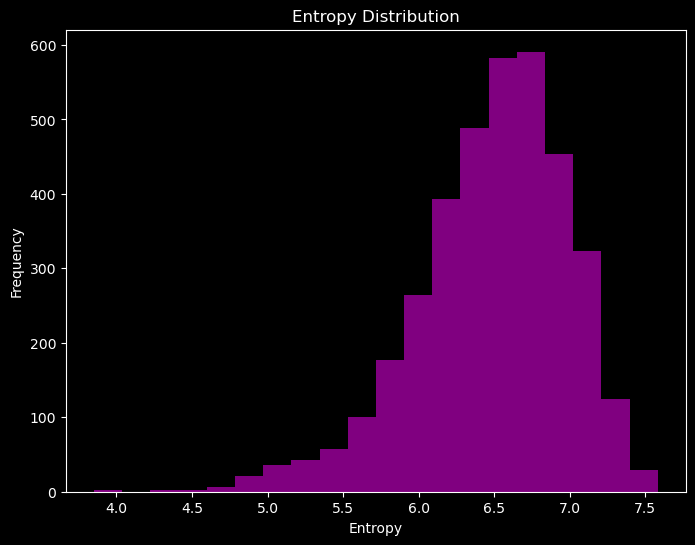

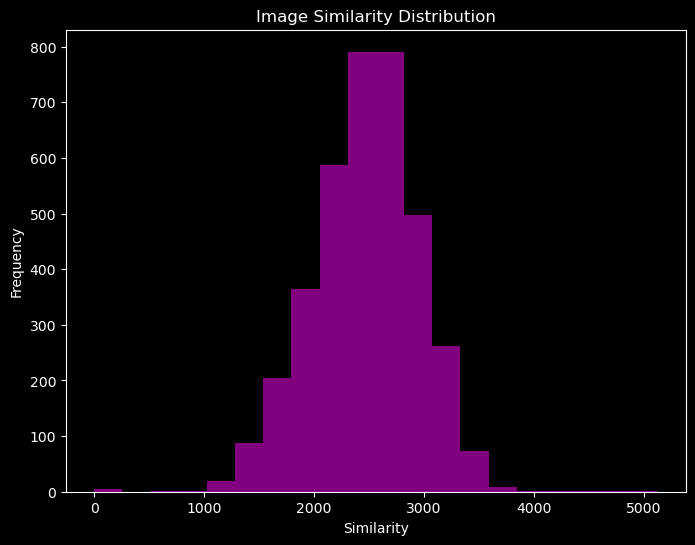

In [3]:
# Plot image size distribution
plt.figure(figsize=(8, 6))
plt.hist([size[0] for size in image_sizes], bins=20, alpha=0.5, color='red', label='Width')
plt.hist([size[1] for size in image_sizes], bins=20, alpha=0.5, color='blue', label='Height')
plt.xlabel('Size (pixels)')
plt.ylabel('Frequency')
plt.title('Image Size Distribution')
plt.legend()
plt.show()

# Plot image format distribution
plt.figure(figsize=(8, 6))
plt.hist(image_formats, color='purple')
plt.xlabel('Image Format')
plt.ylabel('Frequency')
plt.title('Image Format Distribution')
plt.show()

# Plot image sharpness distribution
plt.figure(figsize=(8, 6))
plt.hist(image_sharpness, bins=20, color='purple')
plt.xlabel('Sharpness')
plt.ylabel('Frequency')
plt.title('Image Sharpness Distribution')
plt.show()

# Plot pixel intensity distribution
plt.figure(figsize=(8, 6))
plt.hist(pixel_intensities, bins=20, color='purple')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
plt.show()

# Plot entropy distribution
plt.figure(figsize=(8, 6))
plt.hist(entropies, bins=20, color='purple')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.title('Entropy Distribution')
plt.show()

# Plot image similarity distribution
plt.figure(figsize=(8, 6))
plt.hist(image_similarities, bins=20, color='purple')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Image Similarity Distribution')
plt.show()

In [3]:
We tried LDA as suggested by a few papers on similar topics, but found this technique to be ineffective. 

SyntaxError: invalid syntax (2705811983.py, line 1)

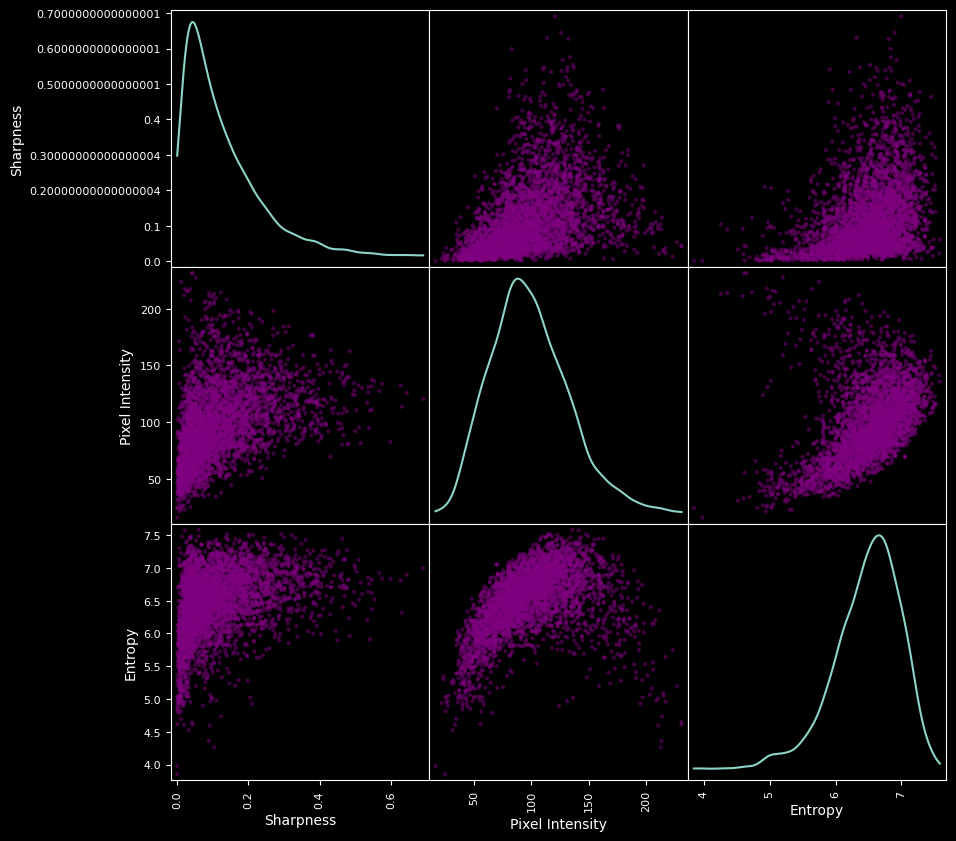

In [5]:
import pandas as pd
from pandas.plotting import scatter_matrix

image_properties = pd.DataFrame({
    'Sharpness': image_sharpness,
    'Pixel Intensity': pixel_intensities,
    'Entropy': entropies
})

scatter_matrix(image_properties, figsize=(10, 10), diagonal='kde', color="purple")
plt.show()

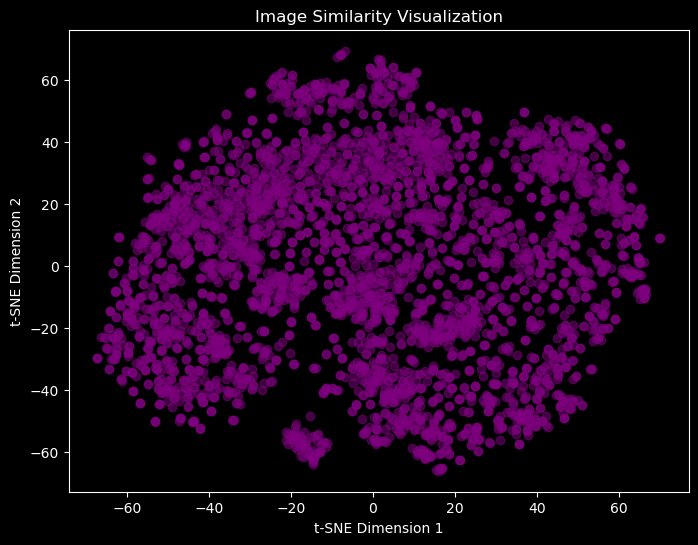

In [6]:
from sklearn.manifold import TSNE
import numpy as np

# Convert image_data list to a NumPy array
image_data_array = np.array(image_data)

tsne = TSNE(n_components=2, random_state=42)
image_embeddings = tsne.fit_transform(image_data_array)

plt.figure(figsize=(8, 6))
plt.scatter(image_embeddings[:, 0], image_embeddings[:, 1], alpha=0.5, color='purple')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Image Similarity Visualization')
plt.show()

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">2.1 Data Ingestion</h1>

In [1]:
# Set the path to your dataset and define the image size
img_size = (28, 28)

# Create lists to store the image paths, shapes, and types
image_paths = []
shapes = []
types = []

dataset_path = 'trafficsigns_dataset'

Custom data labelling function

In [5]:
import os
from sklearn.preprocessing import LabelEncoder
for shape in os.listdir(dataset_path):
    shape_path = os.path.join(dataset_path, shape)
    for sign_type in os.listdir(shape_path):
        type_path = os.path.join(shape_path, sign_type)
        for image_file in os.listdir(type_path):
            image_path = os.path.join(type_path, image_file)
            image_paths.append(image_path)
            shapes.append(shape)
            types.append(sign_type)

# Encode the shape and type labels
shape_encoder = LabelEncoder()
type_encoder = LabelEncoder()

shape_labels = shape_encoder.fit_transform(shapes)
type_labels = type_encoder.fit_transform(types)

# Create a DataFrame with image paths, shape labels, and type labels
df = pd.DataFrame({
    'image_path': image_paths,
    'shape_label': shape_labels,
    'type_label': type_labels
})

In [6]:
# Print the first 3 rows of the DataFrame
df.info()

df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7462 entries, 0 to 7461
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_path   7462 non-null   object
 1   shape_label  7462 non-null   int64 
 2   type_label   7462 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 175.0+ KB


,image_path,shape_label,type_label
0,trafficsigns_dataset/hex/stop/00684_00002.png,1,12
1,trafficsigns_dataset/hex/stop/00685_00002.png,1,12
2,trafficsigns_dataset/hex/stop/00478_00001.png,1,12


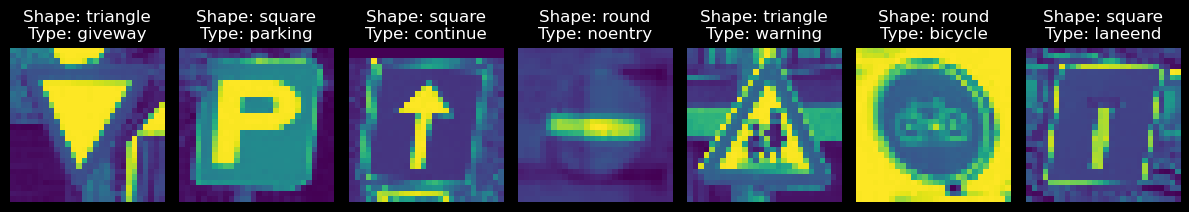

In [99]:
# Display a few randomly selected images with their labels
num_images = 7
random_indices = df.index.to_series().sample(num_images)

fig, axes = plt.subplots(1, num_images, figsize=(12, 4))

for i, idx in enumerate(random_indices):
    image_path = df.loc[idx, 'image_path']
    shape_label = shape_encoder.inverse_transform([df.loc[idx, 'shape_label']])[0]
    type_label = type_encoder.inverse_transform([df.loc[idx, 'type_label']])[0]
    
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].set_title(f"Shape: {shape_label}\nType: {type_label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [100]:
# Check if there are any duplicated rows in the DataFrame
has_duplicates = df.duplicated().any()

# Print out the result
print(f"DuplicateData: {has_duplicates}")

DuplicateData: False


In [101]:
EDA again

SyntaxError: invalid syntax (3304323075.py, line 1)

In [ ]:
import matplotlib.pyplot as plt

# Get the unique labels for each column
shape_labels = shape_encoder.classes_
type_labels = type_encoder.classes_

# Create a grid of subplots
plt.figure(figsize=(15, 6))
for i, col in enumerate(['shape_label', 'type_label']):
    plt.subplot(1, 2, i+1)
    
    # Get the value counts for the current column
    value_counts = df[col].value_counts()
    
    # Get the actual label names using the inverse transform of the encoders
    if col == 'shape_label':
        label_names = shape_encoder.inverse_transform(value_counts.index)
    else:
        label_names = type_encoder.inverse_transform(value_counts.index)
    
    # Plot the value counts as bars
    plt.bar(range(len(label_names)), value_counts, color='purple')
    
    plt.title(col)
    plt.xticks(range(len(label_names)), label_names, rotation=45, ha='right')
    plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">2.2 Data Splitting</h1>

In [7]:
# Custom preprocessing function
def preprocess_input(x):

    # This 
    
    return x / 255.0

In [8]:
import matplotlib.pyplot as plt

# Split the data into train and validation sets
train_indices, val_indices = train_test_split(df.index, test_size=0.2, random_state=42)

# Print the number of items in each dataset
print("Number of images in the training set:", len(train_indices))
print("Number of images in the validation set:", len(val_indices))

# Create data generators for training and validation
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

Number of images in the training set: 5969
Number of images in the validation set: 1493


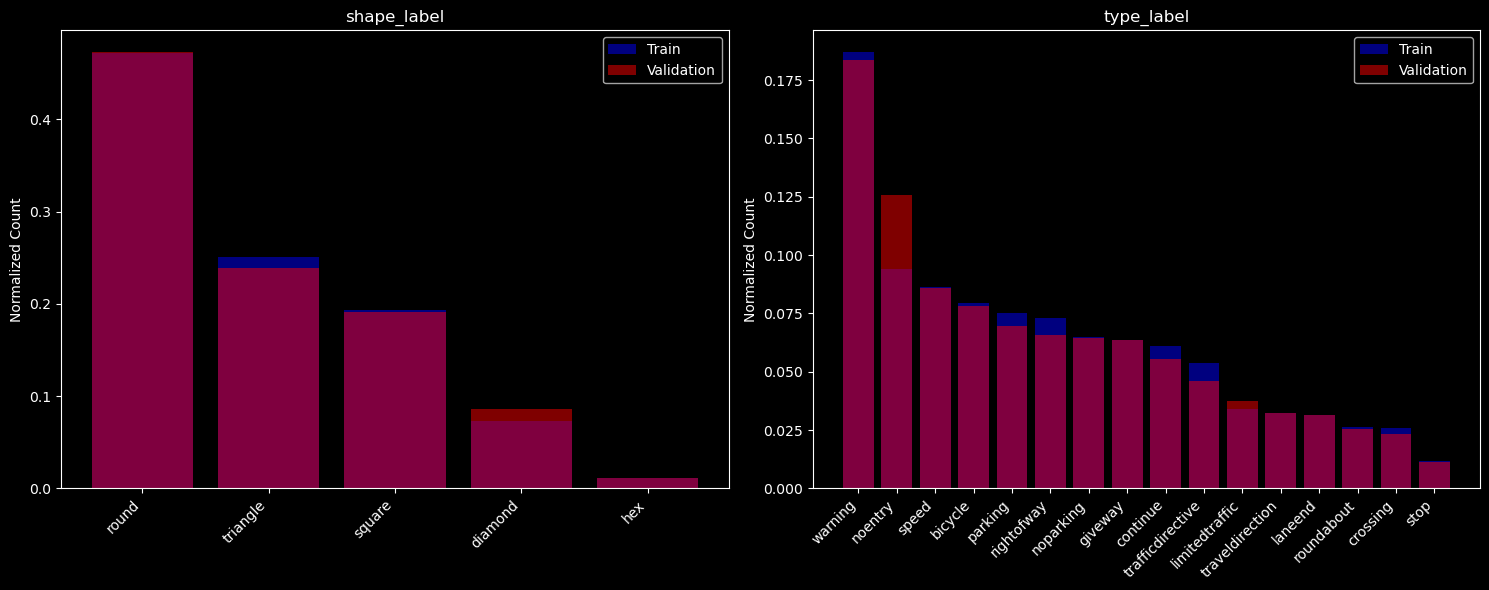

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Get the unique labels for each column
shape_labels = shape_encoder.classes_
type_labels = type_encoder.classes_

# Create a grid of subplots
plt.figure(figsize=(15, 6))

for i, col in enumerate(['shape_label', 'type_label']):
    plt.subplot(1, 2, i+1)

    # Get the value counts for the current column
    train_value_counts = df.loc[train_indices, col].value_counts(normalize=True)
    val_value_counts = df.loc[val_indices, col].value_counts(normalize=True)

    # Get the actual label names using the inverse transform of the encoders
    if col == 'shape_label':
        label_names = shape_encoder.inverse_transform(train_value_counts.index)
    else:
        label_names = type_encoder.inverse_transform(train_value_counts.index)

    # Plot the normalized value counts as bars
    bar_width = 0.8
    x_positions = np.arange(len(label_names))
    plt.bar(x_positions, train_value_counts, bar_width, color='blue', label='Train', alpha=0.5)
    plt.bar(x_positions, val_value_counts, bar_width, color='red', label='Validation', alpha=0.5)

    plt.title(col)
    plt.xticks(x_positions, label_names, rotation=45, ha='right')
    plt.ylabel('Normalized Count')
    plt.legend()
    plt.tight_layout()

plt.show()

In [11]:
# Load and preprocess the image data
def load_and_preprocess_image(image_path):
    img = imageio.imread(image_path)
    img = img / 255.0
    return img.flatten()

# Prepare the input data and labels
X_train = np.array([load_and_preprocess_image(image_path) for image_path in df.iloc[train_indices]['image_path']])
X_val = np.array([load_and_preprocess_image(image_path) for image_path in df.iloc[val_indices]['image_path']])

y_train_shape = df.iloc[train_indices]['shape_label'].values
y_train_type = df.iloc[train_indices]['type_label'].values

y_val_shape = df.iloc[val_indices]['shape_label'].values
y_val_type = df.iloc[val_indices]['type_label'].values

In [17]:
Oversampling

NameError: name 'Oversampling' is not defined

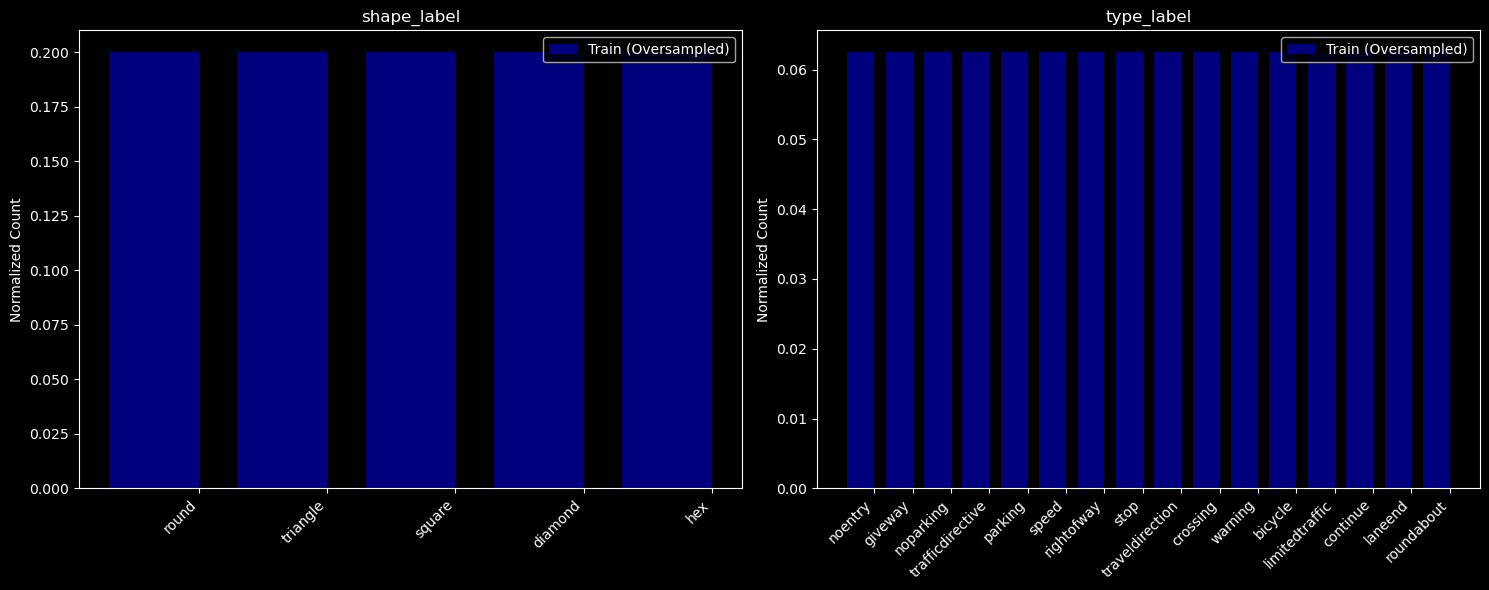

In [68]:
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import RandomOverSampler

# Get the unique labels for each column
shape_labels = shape_encoder.classes_
type_labels = type_encoder.classes_

# Create a grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

for i, (col, ax) in enumerate(zip(['shape_label', 'type_label'], axs)):
    # Oversample the minority classes in the training set
    ros = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(df.loc[train_indices, df.columns != col],
                                                            df.loc[train_indices, col])
    train_value_counts_resampled = pd.Series(y_train_resampled).value_counts(normalize=True)

    # Oversample the minority classes in the validation set
    X_val_resampled, y_val_resampled = ros.fit_resample(df.loc[val_indices, df.columns != col],
                                                        df.loc[val_indices, col])
    val_value_counts_resampled = pd.Series(y_val_resampled).value_counts(normalize=True)

    # Get the actual label names using the inverse transform of the encoders
    label_names = shape_encoder.inverse_transform(train_value_counts_resampled.index) if col == 'shape_label' else type_encoder.inverse_transform(train_value_counts_resampled.index)

    # Plot the normalized value counts after oversampling
    bar_width = 0.7
    x_positions = np.arange(len(label_names))
    ax.bar(x_positions - bar_width / 2, train_value_counts_resampled, bar_width, color='blue', label='Train (Oversampled)', alpha=0.5)
    ax.set_title(col)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(label_names, rotation=45, ha='right')
    ax.set_ylabel('Normalized Count')
    ax.legend()

fig.tight_layout()
plt.show()

In [69]:
# Load and preprocess the image data
def load_and_preprocess_image(image_path):
    img = imageio.imread(image_path)
    img = img / 255.0
    return img.flatten()

# Get the flattened image data and target labels for the training set
X_train_images = np.array([load_and_preprocess_image(image_path) for image_path in df.iloc[train_indices]['image_path']])
y_train_shape = df.iloc[train_indices]['shape_label'].values
y_train_type = df.iloc[train_indices]['type_label'].values

# Get the flattened image data and target labels for the validation set
X_val_images = np.array([load_and_preprocess_image(image_path) for image_path in df.iloc[val_indices]['image_path']])
y_val_shape = df.iloc[val_indices]['shape_label'].values
y_val_type = df.iloc[val_indices]['type_label'].values

# Oversample the minority classes only in the training set
ros = RandomOverSampler(random_state=42)
X_train_shape, y_train_shape = ros.fit_resample(X_train_images, y_train_shape)
X_train_type, y_train_type = ros.fit_resample(X_train_images, y_train_type)

# Truncate the larger array to match the size of the smaller array
min_samples = min(len(X_train_shape), len(X_train_type))
X_train = X_train_shape[:min_samples]
y_train_shape = y_train_shape[:min_samples]
y_train_type = y_train_type[:min_samples]

# Overwrite the validation variables with the non-oversampled data
X_val = X_val_images
y_val_shape = y_val_shape
y_val_type = y_val_type

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">3.0 Logistic Regression Classifier</h1>

In [53]:
MAKE SURE IS ACTUALLY LOGISTIC, AND NOT LINEAR.

SyntaxError: invalid syntax (2723165081.py, line 1)

big difference here is this uses a sigmoid activiation function.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create logistic regression models for shape and type
shape_classifier = LogisticRegression()
type_classifier = LogisticRegression()

# Train the models
shape_classifier.fit(X_train, y_train_shape)
type_classifier.fit(X_train, y_train_type)

# Make predictions on the validation set
shape_pred = shape_classifier.predict(X_val)
type_pred = type_classifier.predict(X_val)

# Evaluate the models
shape_accuracy = accuracy_score(y_val_shape, shape_pred)
shape_precision = precision_score(y_val_shape, shape_pred, average='weighted')
shape_recall = recall_score(y_val_shape, shape_pred, average='weighted')
shape_f1 = f1_score(y_val_shape, shape_pred, average='weighted')

type_accuracy = accuracy_score(y_val_type, type_pred)
type_precision = precision_score(y_val_type, type_pred, average='weighted')
type_recall = recall_score(y_val_type, type_pred, average='weighted')
type_f1 = f1_score(y_val_type, type_pred, average='weighted')

print("Shape Classification:")
print("Accuracy:", shape_accuracy)
print("Precision:", shape_precision)
print("Recall:", shape_recall)
print("F1-score:", shape_f1)

print("Type Classification:")
print("Accuracy:", type_accuracy)
print("Precision:", type_precision)
print("Recall:", type_recall)
print("F1-score:", type_f1)

Shape Classification:
Accuracy: 0.9866041527126591
Precision: 0.9866041527126591
Recall: 0.9866041527126591
F1-score: 0.9866041527126591
Type Classification:
Accuracy: 0.9899531145344943
Precision: 0.990058565623019
Recall: 0.9899531145344943
F1-score: 0.9899611907408341


<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">3.1 Decision Tree Classifier</h1>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">3.1-1 Decision Tree Hyperparameter Tuning</h1>

In [160]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Create Decision Tree classifiers for shape and type
shape_dt = DecisionTreeClassifier(random_state=42)
type_dt = DecisionTreeClassifier(random_state=42)

# Perform GridSearchCV for shape classifier
shape_grid_search = GridSearchCV(shape_dt, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
shape_grid_search.fit(X_train, y_train_shape)

# Perform GridSearchCV for type classifier
type_grid_search = GridSearchCV(type_dt, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
type_grid_search.fit(X_train, y_train_type)

# Print the best parameters for shape classifier
print("Best Parameters for Shape Classifier:")
print(shape_grid_search.best_params_)

# Print the best parameters for type classifier
print("Best Parameters for Type Classifier:")
print(type_grid_search.best_params_)

Best Parameters for Shape Classifier:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Parameters for Type Classifier:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}


<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">3.1-2 Decision Tree Training</h1>

In [161]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create the hypertuned Decision Tree classifiers with the best parameters
shape_dt_best = DecisionTreeClassifier(**shape_grid_search.best_params_, random_state=42)
type_dt_best = DecisionTreeClassifier(**type_grid_search.best_params_, random_state=42)

# Train the hypertuned Decision Tree classifiers
shape_dt_best.fit(X_train, y_train_shape)
type_dt_best.fit(X_train, y_train_type)

DecisionTreeClassifier(criterion='entropy', min_samples_split=5,
                       random_state=42)

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">3.1-3 Decision Tree Validation</h1>

Shape Accuracy: 0.8635135135135135
Type Accuracy: 0.8364864864864865


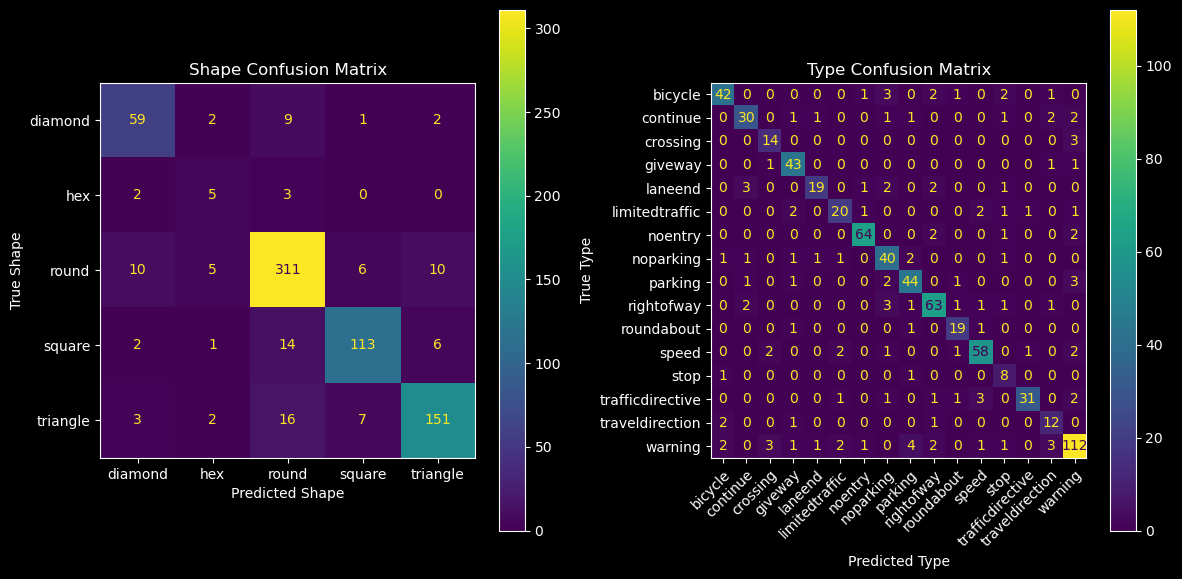

In [162]:
# Make predictions on the validation set
shape_pred = shape_dt_best.predict(X_val)
type_pred = type_dt_best.predict(X_val)

# Evaluate the hypertuned Decision Tree classifiers on the validation set
shape_acc = shape_dt_best.score(X_val, y_val_shape)
type_acc = type_dt_best.score(X_val, y_val_type)

print("Shape Accuracy:", shape_acc)
print("Type Accuracy:", type_acc)

# Create confusion matrices
shape_cm = confusion_matrix(y_val_shape, shape_pred)
type_cm = confusion_matrix(y_val_type, type_pred)

# Plot the confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(shape_cm, display_labels=shape_encoder.classes_).plot(ax=ax1)
ax1.set_title("Shape Confusion Matrix")
ax1.set_xlabel("Predicted Shape")
ax1.set_ylabel("True Shape")

ConfusionMatrixDisplay(type_cm, display_labels=type_encoder.classes_).plot(ax=ax2)
ax2.set_title("Type Confusion Matrix")
ax2.set_xlabel("Predicted Type")
ax2.set_ylabel("True Type")

# Rotate the x-axis labels of the Type Confusion Matrix
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">3.2 Random Forest</h1>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">3.2-1 Decision Tree Hyperparameter Tuning</h1>

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create Random Forest classifiers for shape and type
shape_rf = RandomForestClassifier(random_state=42)
type_rf = RandomForestClassifier(random_state=42)

# Perform GridSearchCV for shape classifier
shape_grid_search = GridSearchCV(shape_rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
shape_grid_search.fit(X_train, y_train_shape)

# Perform GridSearchCV for type classifier
type_grid_search = GridSearchCV(type_rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
type_grid_search.fit(X_train, y_train_type)

# Print the best parameters for shape classifier
print("Best Parameters for Shape Classifier:")
print(shape_grid_search.best_params_)

# Print the best parameters for type classifier
print("Best Parameters for Type Classifier:")
print(type_grid_search.best_params_)

Best Parameters for Shape Classifier:
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Parameters for Type Classifier:
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">3.2-2 Random Forest Training</h1>

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create the hypertuned Random Forest classifiers with the best parameters
shape_rf_best = RandomForestClassifier(**shape_grid_search.best_params_, random_state=42)
type_rf_best = RandomForestClassifier(**type_grid_search.best_params_, random_state=42)

# Train the hypertuned Random Forest classifiers
shape_rf_best.fit(X_train, y_train_shape)
type_rf_best.fit(X_train, y_train_type)

RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">3.2-3 Random Forest Validation</h1>

Shape Accuracy: 0.9540540540540541
Type Accuracy: 0.9594594594594594


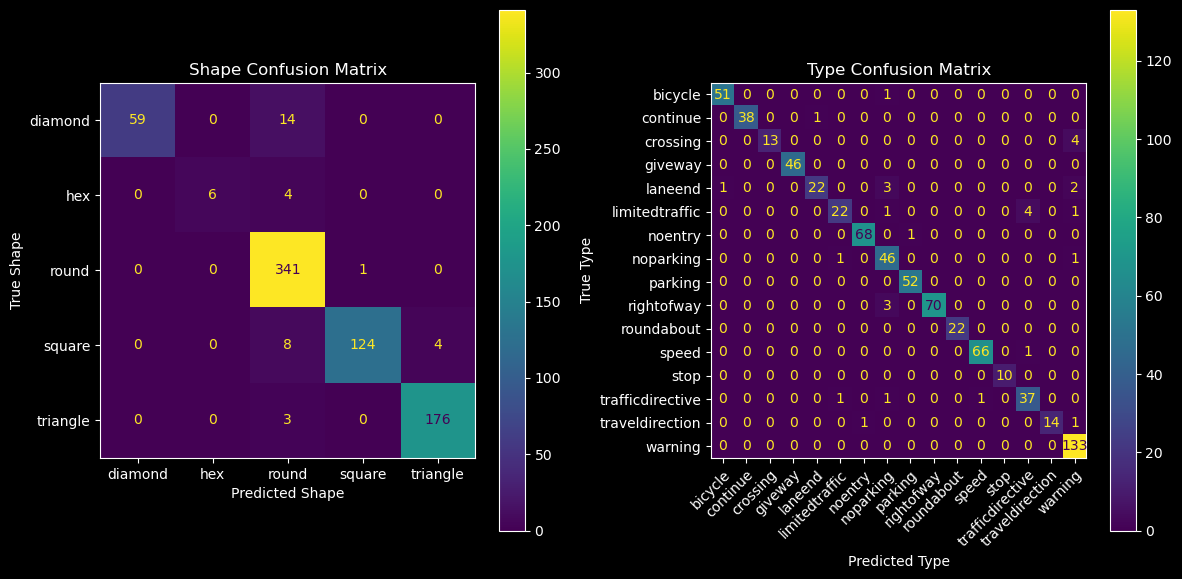

In [31]:
# Make predictions on the validation set
shape_pred = shape_rf_best.predict(X_val)
type_pred = type_rf_best.predict(X_val)

# Evaluate the hypertuned Random Forest classifiers on the validation set
shape_acc = shape_rf_best.score(X_val, y_val_shape)
type_acc = type_rf_best.score(X_val, y_val_type)

print("Shape Accuracy:", shape_acc)
print("Type Accuracy:", type_acc)

# Create confusion matrices
shape_cm = confusion_matrix(y_val_shape, shape_pred)
type_cm = confusion_matrix(y_val_type, type_pred)

# Plot the confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(shape_cm, display_labels=shape_encoder.classes_).plot(ax=ax1)
ax1.set_title("Shape Confusion Matrix")
ax1.set_xlabel("Predicted Shape")
ax1.set_ylabel("True Shape")

ConfusionMatrixDisplay(type_cm, display_labels=type_encoder.classes_).plot(ax=ax2)
ax2.set_title("Type Confusion Matrix")
ax2.set_xlabel("Predicted Type")
ax2.set_ylabel("True Type")

# Rotate the x-axis labels of the Type Confusion Matrix
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">3.3 Gradient Boosted Ensemble Classifier</h1>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">3.3-1 Gradient Boosted Ensemble Classifier Hyperparameter Tuning</h1>

In [56]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the reduced parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2']
}

# Create Gradient Boosting classifiers for shape and type
shape_gb = GradientBoostingClassifier(random_state=42)
type_gb = GradientBoostingClassifier(random_state=42)

# Perform RandomizedSearchCV for shape classifier
shape_random_search = RandomizedSearchCV(shape_gb, param_grid, cv=3, scoring='accuracy', n_jobs=-1, n_iter=10, random_state=42)
shape_random_search.fit(X_train, y_train_shape)

# Perform RandomizedSearchCV for type classifier
type_random_search = RandomizedSearchCV(type_gb, param_grid, cv=3, scoring='accuracy', n_jobs=-1, n_iter=10, random_state=42)
type_random_search.fit(X_train, y_train_type)

# Print the best parameters for shape classifier
print("Best Parameters for Shape Classifier:")
print(shape_random_search.best_params_)

# Print the best parameters for type classifier
print("Best Parameters for Type Classifier:")
print(type_random_search.best_params_)

Best Parameters for Shape Classifier:
{'subsample': 1.0, 'n_estimators': 100, 'max_features': 'log2', 'max_depth': 5, 'learning_rate': 0.1}
Best Parameters for Type Classifier:
{'subsample': 1.0, 'n_estimators': 100, 'max_features': 'log2', 'max_depth': 5, 'learning_rate': 0.1}


<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">3.3-2 Gradient Boosted Ensemble Classifier Training</h1>

In [57]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create the hypertuned Gradient Boosting classifiers with the best parameters
shape_gb_best = GradientBoostingClassifier(**shape_random_search.best_params_, random_state=42)
type_gb_best = GradientBoostingClassifier(**type_random_search.best_params_, random_state=42)

# Train the hypertuned Gradient Boosting classifiers
shape_gb_best.fit(X_train, y_train_shape)
type_gb_best.fit(X_train, y_train_type)

GradientBoostingClassifier(max_depth=5, max_features='log2', random_state=42)

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 24px;">3.3-3 Gradient Boosted Ensemble Classifier Validation</h1>

Shape Accuracy: 0.9486486486486486
Type Accuracy: 0.9445945945945946


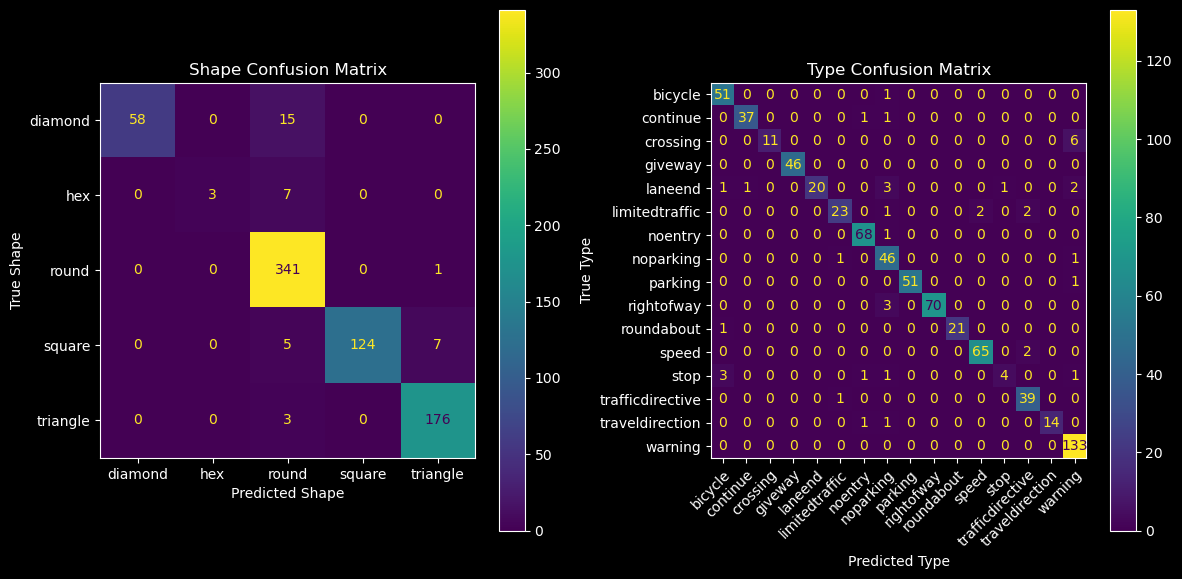

In [58]:
# Make predictions on the validation set
shape_pred = shape_gb_best.predict(X_val)
type_pred = type_gb_best.predict(X_val)

# Evaluate the hypertuned Gradient Boosting classifiers on the validation set
shape_acc = shape_gb_best.score(X_val, y_val_shape)
type_acc = type_gb_best.score(X_val, y_val_type)

print("Shape Accuracy:", shape_acc)
print("Type Accuracy:", type_acc)

# Create confusion matrices
shape_cm = confusion_matrix(y_val_shape, shape_pred)
type_cm = confusion_matrix(y_val_type, type_pred)

# Plot the confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(shape_cm, display_labels=shape_encoder.classes_).plot(ax=ax1)
ax1.set_title("Shape Confusion Matrix")
ax1.set_xlabel("Predicted Shape")
ax1.set_ylabel("True Shape")

ConfusionMatrixDisplay(type_cm, display_labels=type_encoder.classes_).plot(ax=ax2)
ax2.set_title("Type Confusion Matrix")
ax2.set_xlabel("Predicted Type")
ax2.set_ylabel("True Type")

# Rotate the x-axis labels of the Type Confusion Matrix
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">4.0 Neural Networks</h1>

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">4.1 Multi-Layer-Perceptron Classifier (Baseline Model)</h1>

In [ ]:
what a MLP is. 

In [109]:
import keras
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df.iloc[train_indices],
    x_col='image_path',
    y_col=['shape_label', 'type_label'],
    target_size=img_size,
    batch_size=32,
    class_mode='multi_output'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df.iloc[val_indices],
    x_col='image_path',
    y_col=['shape_label', 'type_label'],
    target_size=img_size,
    batch_size=32,
    class_mode='multi_output'
)

# Define the input shape and number of classes
input_shape = (28, 28, 3)
num_shape_classes = len(shape_encoder.classes_)
num_type_classes = len(type_encoder.classes_)

# Create the model architecture
inputs = keras.Input(shape=input_shape)
x = Flatten()(inputs)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layers for shape and type
shape_output = Dense(num_shape_classes, activation='softmax', name='shape')(x)
type_output = Dense(num_type_classes, activation='softmax', name='type')(x)

# Create the model
model = Model(inputs=inputs, outputs=[shape_output, type_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'shape': 'sparse_categorical_crossentropy',
                    'type': 'sparse_categorical_crossentropy'},
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_indices) // 32,
    validation_data=val_generator,
    validation_steps=np.ceil(len(val_indices) / 32).astype(int),
    epochs=10
)

Found 2984 validated image filenames.
Found 747 validated image filenames.
Epoch 1/10


2024-05-12 15:31:59.952837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


93/93 [==============================] - ETA: 0s - loss: 3.7682 - shape_loss: 1.2506 - type_loss: 2.5176 - shape_accuracy: 0.5183 - type_accuracy: 0.2520

2024-05-12 15:32:03.310513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


93/93 [==============================] - 5s 45ms/step - loss: 3.7682 - shape_loss: 1.2506 - type_loss: 2.5176 - shape_accuracy: 0.5183 - type_accuracy: 0.2520 - val_loss: 2.7333 - val_shape_loss: 0.8697 - val_type_loss: 1.8636 - val_shape_accuracy: 0.6774 - val_type_accuracy: 0.4485
Epoch 2/10
93/93 [==============================] - 4s 46ms/step - loss: 2.4663 - shape_loss: 0.7581 - type_loss: 1.7082 - shape_accuracy: 0.7131 - type_accuracy: 0.4685 - val_loss: 1.8732 - val_shape_loss: 0.5834 - val_type_loss: 1.2898 - val_shape_accuracy: 0.7724 - val_type_accuracy: 0.6118
Epoch 3/10
93/93 [==============================] - 3s 36ms/step - loss: 1.9379 - shape_loss: 0.5796 - type_loss: 1.3583 - shape_accuracy: 0.7967 - type_accuracy: 0.5766 - val_loss: 1.2921 - val_shape_loss: 0.3598 - val_type_loss: 0.9324 - val_shape_accuracy: 0.9009 - val_type_accuracy: 0.7296
Epoch 4/10
93/93 [==============================] - 3s 32ms/step - loss: 1.6229 - shape_loss: 0.4857 - type_loss: 1.1372 - sha

Evaluation Metrics DO HERE!!!!!!!!!!!!!!!!!!!!

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">4.2 Convolutional Neural Network</h1>

In [ ]:
how CNN differs from MLPs

In [ ]:
add regularization, dropouts, kernel, input reduction, filters, etc. 
try transfer learning - then you can do finetuning.
do hyperparameter tuning using gridsearch on CNN PROBABLY USE BAYESIAN SEARCH INSTEAD. 
add an explicit MLP baseline,

and then make a CNN based on the paper

In [90]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, concatenate
from keras.models import Model
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df.iloc[train_indices],
    x_col='image_path',
    y_col=['shape_label', 'type_label'],
    target_size=img_size,
    batch_size=32,
    class_mode='multi_output'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df.iloc[val_indices],
    x_col='image_path',
    y_col=['shape_label', 'type_label'],
    target_size=img_size,
    batch_size=32,
    class_mode='multi_output'
)

# Define the input shape and number of classes
input_shape = (28, 28, 3)
num_shape_classes = len(shape_encoder.classes_)
num_type_classes = len(type_encoder.classes_)

# Define the number of trees (branches) in the random forest
num_trees = 5

# Create the model architecture
inputs = keras.Input(shape=input_shape)

# Create multiple parallel branches (trees)
branch_outputs = []
for _ in range(num_trees):
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    branch_outputs.append(x)

# Concatenate the outputs from all branches
concat_output = concatenate(branch_outputs)

# Output layers for shape and type
shape_output = Dense(num_shape_classes, activation='softmax', name='shape')(concat_output)
type_output = Dense(num_type_classes, activation='softmax', name='type')(concat_output)

# Create the model
model = Model(inputs=inputs, outputs=[shape_output, type_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'shape': 'sparse_categorical_crossentropy',
                    'type': 'sparse_categorical_crossentropy'},
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_indices) // 32,
    validation_data=val_generator,
    validation_steps=np.ceil(len(val_indices) / 32).astype(int),
    epochs=20
)

Found 2959 validated image filenames.
Found 740 validated image filenames.
Epoch 1/20


2024-05-12 14:24:56.684512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - ETA: 0s - loss: 2.1855 - shape_loss: 0.6814 - type_loss: 1.5041 - shape_accuracy: 0.7721 - type_accuracy: 0.5880

2024-05-12 14:26:26.575306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - 91s 971ms/step - loss: 2.1855 - shape_loss: 0.6814 - type_loss: 1.5041 - shape_accuracy: 0.7721 - type_accuracy: 0.5880 - val_loss: 0.9322 - val_shape_loss: 0.3181 - val_type_loss: 0.6141 - val_shape_accuracy: 0.9122 - val_type_accuracy: 0.8419
Epoch 2/20
92/92 [==============================] - 93s 1s/step - loss: 0.5234 - shape_loss: 0.1724 - type_loss: 0.3510 - shape_accuracy: 0.9552 - type_accuracy: 0.9221 - val_loss: 0.3668 - val_shape_loss: 0.1285 - val_type_loss: 0.2383 - val_shape_accuracy: 0.9581 - val_type_accuracy: 0.9392
Epoch 3/20
92/92 [==============================] - 84s 908ms/step - loss: 0.2524 - shape_loss: 0.0705 - type_loss: 0.1819 - shape_accuracy: 0.9816 - type_accuracy: 0.9573 - val_loss: 0.3416 - val_shape_loss: 0.1556 - val_type_loss: 0.1861 - val_shape_accuracy: 0.9500 - val_type_accuracy: 0.9554
Epoch 4/20
92/92 [==============================] - 86s 943ms/step - loss: 0.1538 - shape_loss: 0.0430 - type_loss: 0.1109 

In [ ]:
tester

In [1]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input

# Define the input shape and number of classes
input_shape = (32, 32, 3)  # Assuming your input images are 32x32 with 3 channels
num_shape_classes = len(shape_encoder.classes_)
num_type_classes = len(type_encoder.classes_)

# Create the model architecture
inputs = Input(shape=input_shape)
x = Conv2D(50, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=input_shape)(inputs)
x = Conv2D(75, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Conv2D(125, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(500, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(250, activation='relu')(x)
x = Dropout(0.3)(x)

# Output layers for shape and type
shape_output = Dense(num_shape_classes, activation='softmax')(x)
type_output = Dense(num_type_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=[shape_output, type_output])

# Compile the model
model.compile(optimizer='adam',
              loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'],
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_indices) // 32,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=20
)

NameError: name 'shape_encoder' is not defined

In [94]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df.iloc[train_indices],
    x_col='image_path',
    y_col=['shape_label', 'type_label'],
    target_size=img_size,
    batch_size=32,
    class_mode='multi_output'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df.iloc[val_indices],
    x_col='image_path',
    y_col=['shape_label', 'type_label'],
    target_size=img_size,
    batch_size=32,
    class_mode='multi_output'
)

# Define the input shape and number of classes
input_shape = (28, 28, 3)
num_shape_classes = len(shape_encoder.classes_)
num_type_classes = len(type_encoder.classes_)

# Create the model architecture
inputs = keras.Input(shape=input_shape)
x = Conv2D(16, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = GlobalAveragePooling2D()(x)  # Use GlobalAveragePooling2D instead of Flatten
x = Dense(64, activation='relu')(x)

# Output layers for shape and type
shape_output = Dense(num_shape_classes, activation='softmax', name='shape')(x)
type_output = Dense(num_type_classes, activation='softmax', name='type')(x)

# Create the model
model = Model(inputs=inputs, outputs=[shape_output, type_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'shape': 'sparse_categorical_crossentropy',
                    'type': 'sparse_categorical_crossentropy'},
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_indices) // 32,
    validation_data=val_generator,
    validation_steps=np.ceil(len(val_indices) / 32).astype(int),
    epochs=20
)

Found 2959 validated image filenames.
Found 740 validated image filenames.
Epoch 1/20


2024-05-11 14:22:41.301809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - ETA: 0s - loss: 3.9330 - shape_loss: 1.2979 - type_loss: 2.6350 - shape_accuracy: 0.4694 - type_accuracy: 0.1807

2024-05-11 14:23:06.563412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - 26s 275ms/step - loss: 3.9330 - shape_loss: 1.2979 - type_loss: 2.6350 - shape_accuracy: 0.4694 - type_accuracy: 0.1807 - val_loss: 3.9312 - val_shape_loss: 1.3248 - val_type_loss: 2.6064 - val_shape_accuracy: 0.4622 - val_type_accuracy: 0.1797
Epoch 2/20
92/92 [==============================] - 23s 250ms/step - loss: 3.8469 - shape_loss: 1.2629 - type_loss: 2.5840 - shape_accuracy: 0.4786 - type_accuracy: 0.1889 - val_loss: 3.8953 - val_shape_loss: 1.3125 - val_type_loss: 2.5828 - val_shape_accuracy: 0.4622 - val_type_accuracy: 0.1797
Epoch 3/20
92/92 [==============================] - 25s 274ms/step - loss: 3.7978 - shape_loss: 1.2461 - type_loss: 2.5517 - shape_accuracy: 0.4804 - type_accuracy: 0.1917 - val_loss: 3.8264 - val_shape_loss: 1.2894 - val_type_loss: 2.5370 - val_shape_accuracy: 0.4622 - val_type_accuracy: 0.1797
Epoch 4/20
92/92 [==============================] - 24s 257ms/step - loss: 3.7235 - shape_loss: 1.2209 - type_loss: 2.50

In [ ]:
bayesian

In [66]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from bayes_opt import BayesianOptimization
import numpy as np

def build_model(learning_rate, dropout_rate, dense_units):
    # Define the input shape and number of classes
    input_shape = (32, 32, 3)
    num_shape_classes = len(shape_encoder.classes_)
    num_type_classes = len(type_encoder.classes_)

    # Load the pre-trained VGG16 model without the top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Create the model architecture
    x = base_model.output
    x = Flatten()(x)
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    # Output layers for shape and type
    shape_output = Dense(num_shape_classes, activation='softmax', name='shape')(x)
    type_output = Dense(num_type_classes, activation='softmax', name='type')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=[shape_output, type_output])

    # Compile the model
    model.compile(optimizer=Adam(lr=learning_rate),
                  loss={'shape': 'sparse_categorical_crossentropy',
                        'type': 'sparse_categorical_crossentropy'},
                  metrics=['accuracy'])

    return model

def objective_function(learning_rate, dropout_rate, dense_units):
    # Build the model with the given hyperparameters
    model = build_model(learning_rate, dropout_rate, dense_units)

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_indices) // 32,
        validation_data=val_generator,
        validation_steps=len(val_indices) // 32,  # Use integer division
        epochs=10,
        verbose=0
    )

    # Return the best validation accuracy as the objective value
    return max(history.history['val_shape_accuracy'])  # Use 'val_shape_accuracy' instead of 'val_accuracy'

# Define the hyperparameter search space
pbounds = {
    'learning_rate': (1e-5, 1e-2),
    'dropout_rate': (0.1, 0.5),
    'dense_units': (32, 512)
}

# Create an instance of BayesianOptimization
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    random_state=42
)

# Perform the Bayesian optimization
optimizer.maximize(init_points=5, n_iter=25)

# Print the best hyperparameters and the corresponding accuracy
print("Best hyperparameters:", optimizer.max)

|   iter    |  target   | dense_... | dropou... | learni... |
-------------------------------------------------------------


2024-05-11 12:44:48.052329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-05-11 12:45:02.588102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


| 1         | 0.966     | 211.8     | 0.4803    | 0.007323  |


2024-05-11 12:47:59.814351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-05-11 12:48:15.643066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


| 2         | 0.9674    | 319.4     | 0.1624    | 0.001568  |


2024-05-11 12:51:12.069453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-05-11 12:51:28.031149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


| 3         | 0.9497    | 59.88     | 0.4465    | 0.006015  |


2024-05-11 12:54:31.320807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-05-11 12:54:46.486133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


| 4         | 0.9728    | 371.9     | 0.1082    | 0.009699  |


2024-05-11 12:57:48.241830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-05-11 12:58:03.201002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


| 5         | 0.9715    | 431.6     | 0.1849    | 0.001826  |


2024-05-11 13:01:06.069114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-05-11 13:01:21.821633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


KeyboardInterrupt: 

1/1 [==============================] - 0s 117ms/step
Confusion matrices created.


<Figure size 800x600 with 0 Axes>

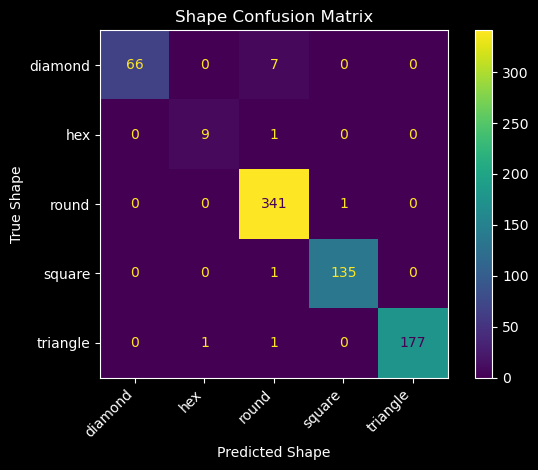

<Figure size 800x600 with 0 Axes>

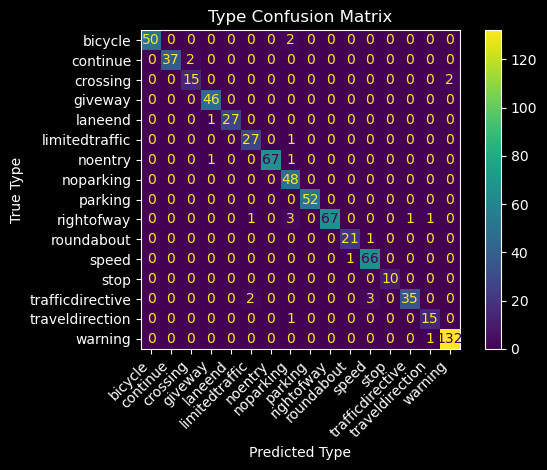

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize empty lists to store the true labels and predicted labels
shape_true_labels = []
type_true_labels = []
shape_pred_labels = []
type_pred_labels = []

# Specify the number of batches to process
num_batches = 24  # Process 24 batches (740 images with batch size 32)

# Iterate over the validation data in batches
batch_count = 0
for batch_data, batch_labels in val_generator:
    # Generate predictions for the current batch
    batch_preds = model.predict(batch_data)
    shape_preds = np.argmax(batch_preds[0], axis=1)
    type_preds = np.argmax(batch_preds[1], axis=1)

    # Append the true labels and predicted labels to the lists
    shape_true_labels.extend(batch_labels[0])
    type_true_labels.extend(batch_labels[1])
    shape_pred_labels.extend(shape_preds)
    type_pred_labels.extend(type_preds)

    batch_count += 1
    if batch_count >= num_batches:
        break  # Exit the loop after processing the specified number of batches

# Map the predicted labels back to their original names
shape_labels_map = {i: label for i, label in enumerate(shape_encoder.classes_)}
type_labels_map = {i: label for i, label in enumerate(type_encoder.classes_)}

# Create confusion matrices for shape and type
shape_cm = confusion_matrix(shape_true_labels, shape_pred_labels)
type_cm = confusion_matrix(type_true_labels, type_pred_labels)

print("Confusion matrices created.")

# Plot the confusion matrix for shape
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(shape_cm, display_labels=shape_encoder.classes_).plot()
plt.title("Shape Confusion Matrix")
plt.xlabel("Predicted Shape")
plt.ylabel("True Shape")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Plot the confusion matrix for type
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(type_cm, display_labels=type_encoder.classes_).plot()
plt.title("Type Confusion Matrix")
plt.xlabel("Predicted Type")
plt.ylabel("True Type")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

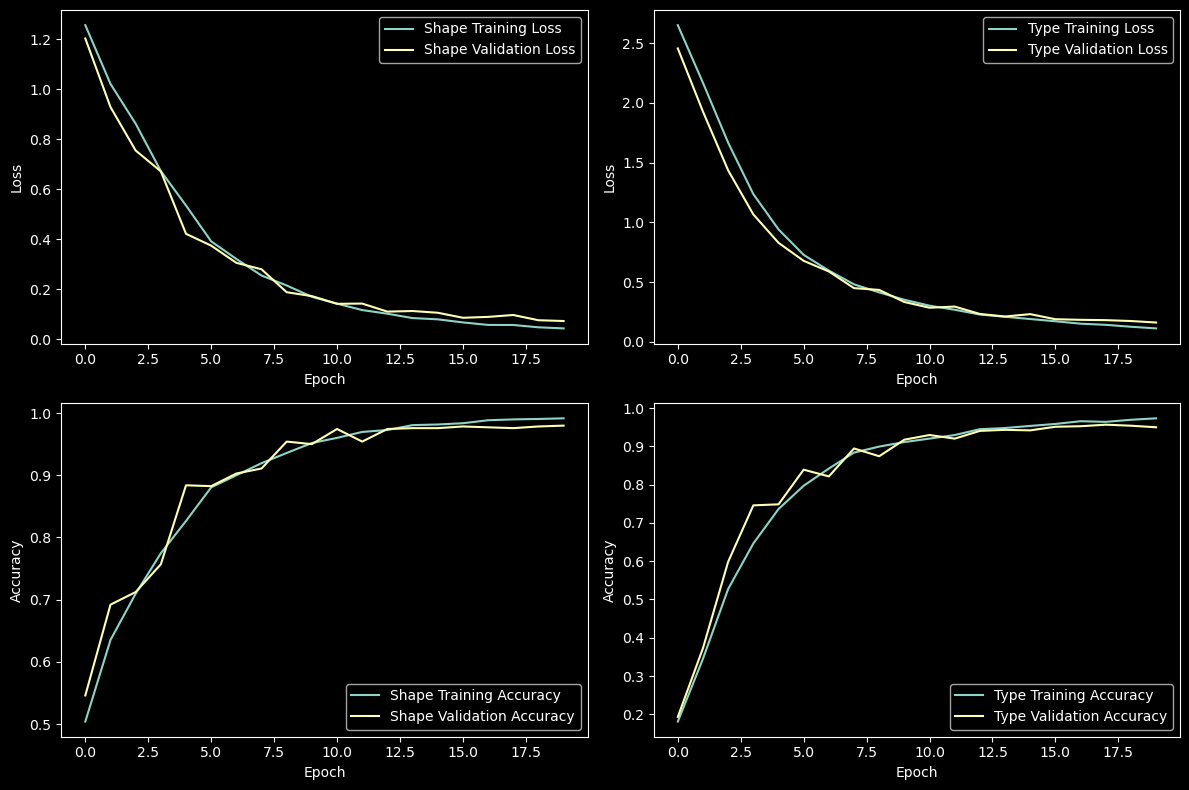

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Plot the learning curves
plt.figure(figsize=(12, 8))

# Plot loss curves
plt.subplot(2, 2, 1)
plt.plot(history.history['shape_loss'], label='Shape Training Loss')
plt.plot(history.history['val_shape_loss'], label='Shape Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['type_loss'], label='Type Training Loss')
plt.plot(history.history['val_type_loss'], label='Type Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy curves
plt.subplot(2, 2, 3)
plt.plot(history.history['shape_accuracy'], label='Shape Training Accuracy')
plt.plot(history.history['val_shape_accuracy'], label='Shape Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history.history['type_accuracy'], label='Type Training Accuracy')
plt.plot(history.history['val_type_accuracy'], label='Type Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
loss and learning rate in report

SyntaxError: invalid syntax (2963133039.py, line 1)

In [209]:
# Evaluate the model on the validation set
val_loss, val_shape_loss, val_type_loss, val_shape_acc, val_type_acc = model.evaluate(val_generator, steps=len(val_indices) // 32)

# Print the validation metrics
print("Validation Loss:", val_loss)
print("Validation Shape Loss:", val_shape_loss)
print("Validation Type Loss:", val_type_loss)
print("Validation Shape Accuracy:", val_shape_acc)
print("Validation Type Accuracy:", val_type_acc)

 2/23 [=>............................] - ETA: 1s - loss: 0.2178 - shape_loss: 9.6678e-04 - type_loss: 0.0338 - shape_accuracy: 1.0000 - type_accuracy: 0.9688

2024-05-11 00:12:26.387380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - 3s 131ms/step - loss: 0.2469 - shape_loss: 0.0188 - type_loss: 0.0451 - shape_accuracy: 0.9959 - type_accuracy: 0.9864
Validation Loss: 0.2469007521867752
Validation Shape Loss: 0.01877007633447647
Validation Type Loss: 0.04506831616163254
Validation Shape Accuracy: 0.9959239363670349
Validation Type Accuracy: 0.9864130616188049


In [58]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d_28 (Conv2D)             (None, 28, 28, 32)   896         ['input_12[0][0]']               
                                                                                                  
 conv2d_29 (Conv2D)             (None, 28, 28, 32)   9248        ['conv2d_28[0][0]']              
                                                                                                  
 max_pooling2d_28 (MaxPooling2D  (None, 14, 14, 32)  0           ['conv2d_29[0][0]']              
 )                                                                                         

1/1 [==============================] - 0s 49ms/step


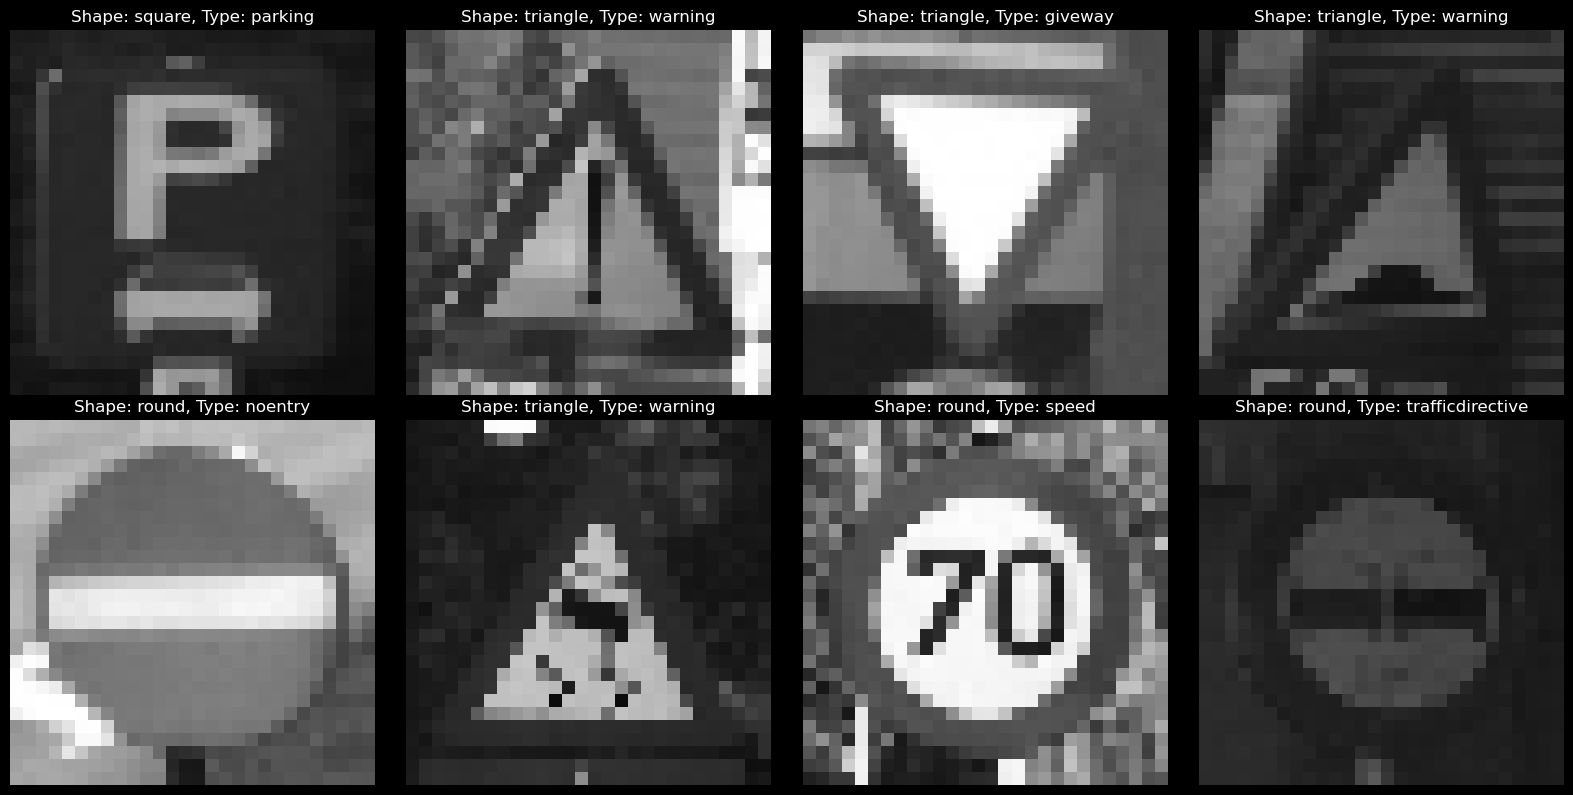

In [34]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Create a figure with 2 rows and 4 columns
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

# Loop through 8 random examples
for i in range(8):
    # Select a random image path from the validation set
    random_index = np.random.choice(val_indices)
    image_path = df.iloc[random_index]['image_path']
    
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Make predictions
    shape_pred, type_pred = model.predict(x)
    
    # Get the predicted shape and type labels
    shape_label = shape_encoder.inverse_transform([np.argmax(shape_pred)])[0]
    type_label = type_encoder.inverse_transform([np.argmax(type_pred)])[0]
    
    # Display the tested image
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Shape: {shape_label}, Type: {type_label}")

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()

# KNN & ISODATA & MAXIMUM-LIKELIHOOD, 

<div style="width:100%; text-align: center; padding: 20px; background-color: #333; border-radius: 10px;">
    <h1 style="color:#7D3C98; font-size: 36px;">Independent Evaluation</h1>

In [37]:
-BEST IDEA IS TO GATHER INCORRECT, AND CORRECT DATA TO TEST.
we used both the german sister dataset, and collected 200 of my own images


SyntaxError: invalid syntax (1473448344.py, line 1)

In [38]:
print("\nValidation set counts:")
print("Shape labels:")
print(df.loc[val_indices, 'shape_label'].map(dict(enumerate(shape_labels))).value_counts())
print("\nType labels:")
print(df.loc[val_indices, 'type_label'].map(dict(enumerate(type_labels))).value_counts())


Validation set counts:
Shape labels:
shape_label
round       342
triangle    179
square      136
diamond      73
hex          10
Name: count, dtype: int64

Type labels:
type_label
warning             133
rightofway           73
noentry              69
speed                67
parking              52
bicycle              52
noparking            48
giveway              46
trafficdirective     40
continue             39
laneend              28
limitedtraffic       28
roundabout           22
crossing             17
traveldirection      16
stop                 10
Name: count, dtype: int64


In [49]:
import os
import numpy as np
from PIL import Image
from skimage import transform
from skimage.color import rgb2gray

def process_images(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Get the file extension
            _, extension = os.path.splitext(file)

            # Check if the file is an image
            if extension.lower() in ['.png', '.ppm']:
                # Construct the full file paths
                input_path = os.path.join(root, file)
                output_path = os.path.join(root, os.path.splitext(file)[0] + '.png')

                try:
                    # Open the image file
                    with Image.open(input_path) as img:
                        # Convert the image to grayscale
                        grayscale_img = img.convert('L')

                        # Resize the grayscale image to 28x28 pixels
                        resized_img = grayscale_img.resize((28, 28))

                        # Save the processed image as PNG, using the new file extension
                        resized_img.save(output_path)

                        # Check if the original file is a .ppm file
                        if extension.lower() == '.ppm':
                            # Delete the original .ppm file
                            os.remove(input_path)

                except Exception as e:
                    print(f"Error processing {input_path}: {str(e)}")

# Directory to start the recursive processing
directory = "independent_dataset"

# Call the function to process and save the images
process_images(directory)

In [50]:
test_dataset_path = 'independent_dataset'
# change to 32 to test transfer learning
img_size = (28, 28)

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, measure
from scipy.spatial.distance import euclidean

# Directory containing the image dataset
dataset_dir = 'independent_dataset'

# Function to get all image files in subdirectories
def get_image_files(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('.png')):
                image_files.append(os.path.join(root, file))
    return image_files

# Get the list of image files
image_files = get_image_files(dataset_dir)
print("Number of image files found:", len(image_files))

# Initialize lists to store image properties
image_sizes = []
image_formats = []
image_colors = []
image_sharpness = []
pixel_intensities = []
entropies = []
image_similarities = []
image_data = []

# Iterate over the image files
for image_path in image_files:
    try:
        image = io.imread(image_path, as_gray=True)
        
        # Get image size
        height, width = image.shape
        image_sizes.append((width, height))
        
        # Get image format
        image_format = os.path.splitext(image_path)[1][1:]
        image_formats.append(image_format)
        
        # Check if the image is grayscale or color
        if len(image.shape) == 2:
            image_colors.append('grayscale')
        else:
            image_colors.append('color')
        
        # Calculate image sharpness using the variance of the Laplacian
        sharpness = np.var(filters.laplace(image))
        image_sharpness.append(sharpness)
        
        # Calculate average pixel intensity
        pixel_intensity = np.mean(image)
        pixel_intensities.append(pixel_intensity)
        
        # Calculate image entropy
        entropy = measure.shannon_entropy(image)
        entropies.append(entropy)
        
        # Store image data for similarity calculation
        image_data.append(image.flatten())
        
        # Domain-specific analysis for road sign classification/shape
        # Example: Extract shape features using Hu moments
        moments = measure.moments_hu(image)
        # Perform further analysis or classification based on the extracted features
        
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")

# Calculate image similarities
for i, img1 in enumerate(image_data):
    if i == 0:
        image_similarities.append(0)
    else:
        distances = [euclidean(img1, img2) for img2 in image_data[:i]]
        image_similarities.append(np.min(distances))

Number of image files found: 682


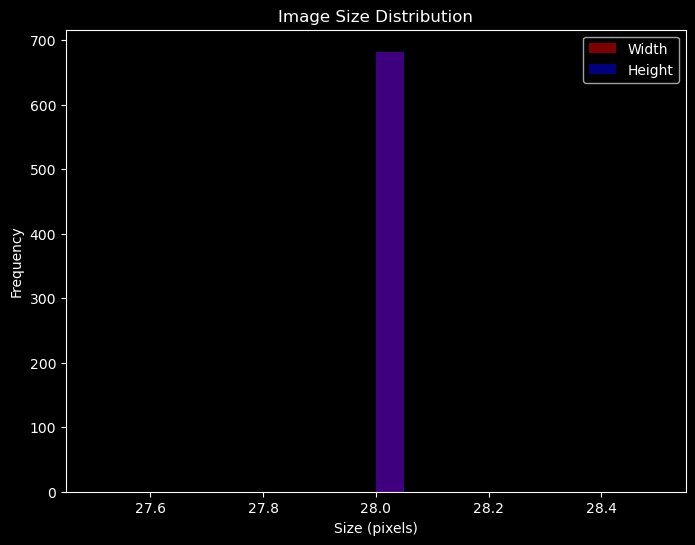

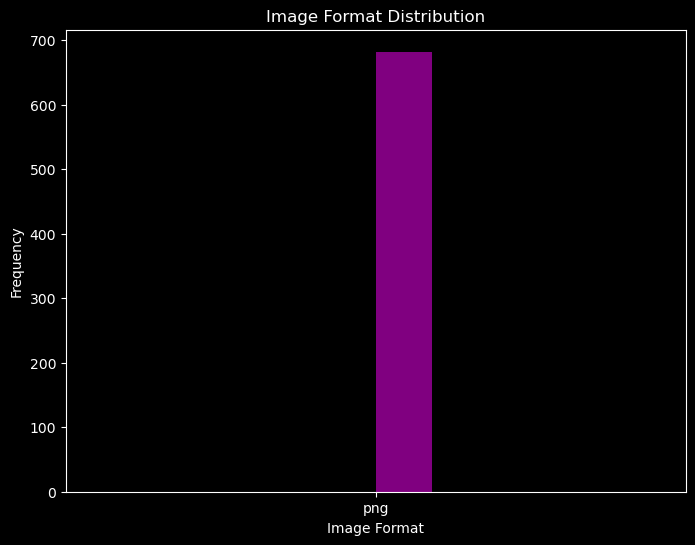

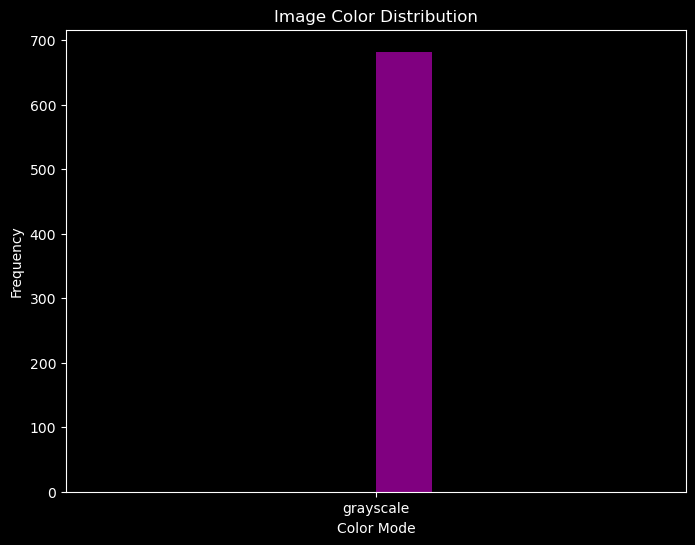

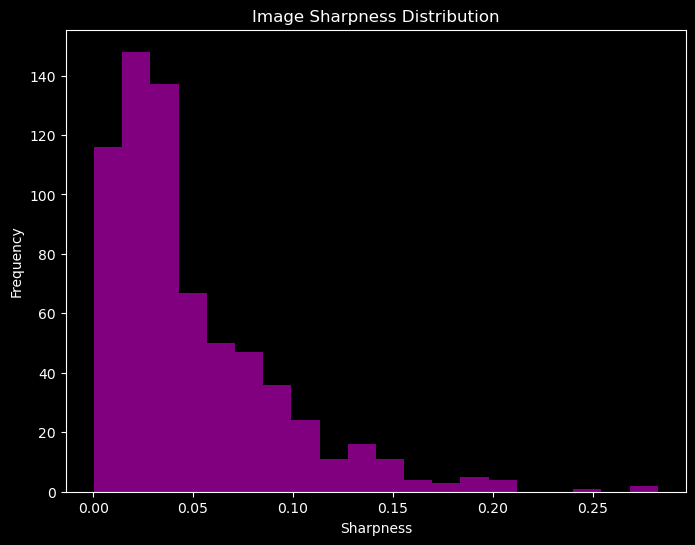

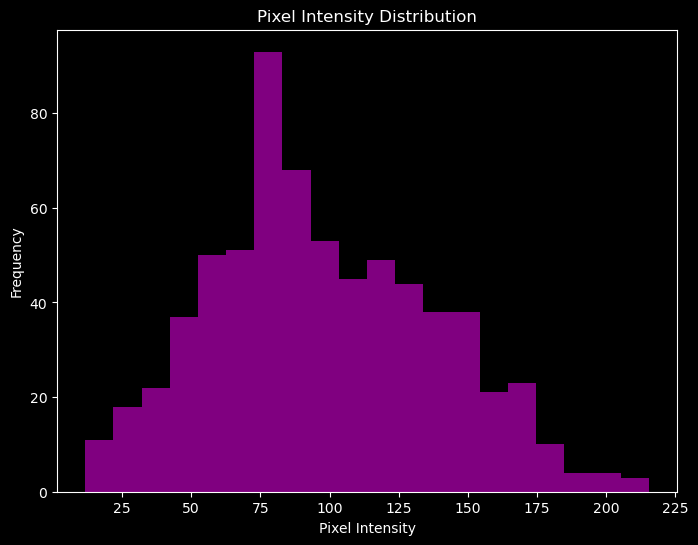

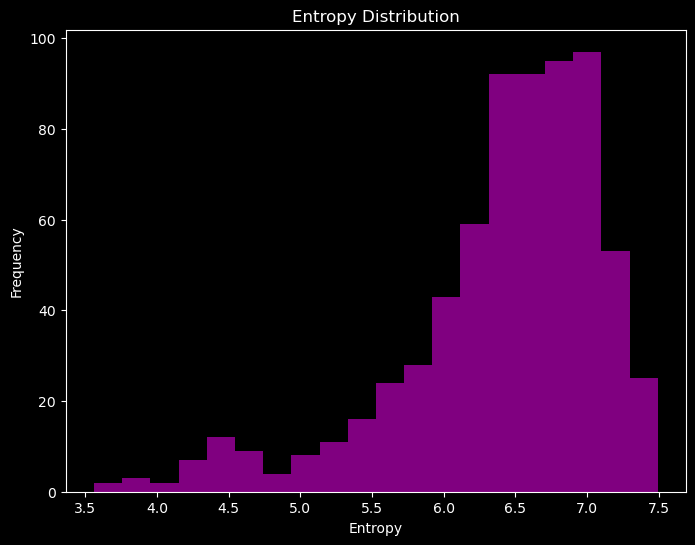

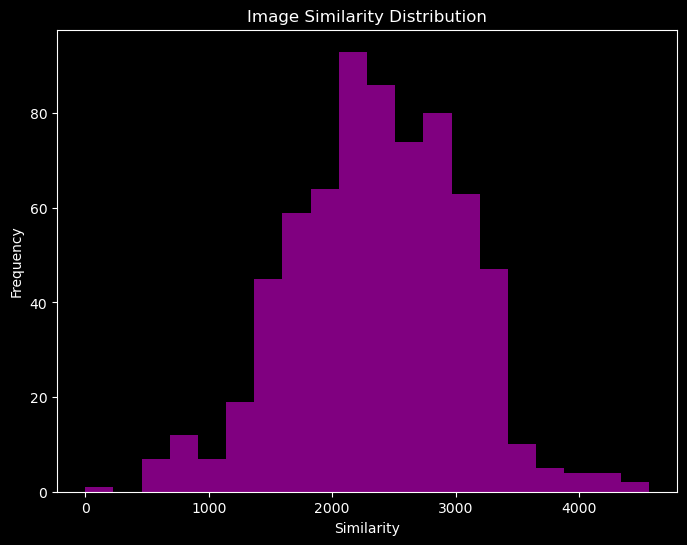

In [52]:
# Plot image size distribution
plt.figure(figsize=(8, 6))
plt.hist([size[0] for size in image_sizes], bins=20, alpha=0.5, color='red', label='Width')
plt.hist([size[1] for size in image_sizes], bins=20, alpha=0.5, color='blue', label='Height')
plt.xlabel('Size (pixels)')
plt.ylabel('Frequency')
plt.title('Image Size Distribution')
plt.legend()
plt.show()

# Plot image format distribution
plt.figure(figsize=(8, 6))
plt.hist(image_formats, color='purple')
plt.xlabel('Image Format')
plt.ylabel('Frequency')
plt.title('Image Format Distribution')
plt.show()

# Plot image color distribution
plt.figure(figsize=(8, 6))
plt.hist(image_colors, color='purple')
plt.xlabel('Color Mode')
plt.ylabel('Frequency')
plt.title('Image Color Distribution')
plt.show()

# Plot image sharpness distribution
plt.figure(figsize=(8, 6))
plt.hist(image_sharpness, bins=20, color='purple')
plt.xlabel('Sharpness')
plt.ylabel('Frequency')
plt.title('Image Sharpness Distribution')
plt.show()

# Plot pixel intensity distribution
plt.figure(figsize=(8, 6))
plt.hist(pixel_intensities, bins=20, color='purple')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
plt.show()

# Plot entropy distribution
plt.figure(figsize=(8, 6))
plt.hist(entropies, bins=20, color='purple')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.title('Entropy Distribution')
plt.show()

# Plot image similarity distribution
plt.figure(figsize=(8, 6))
plt.hist(image_similarities, bins=20, color='purple')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Image Similarity Distribution')
plt.show()

Number of images in the test set: 682


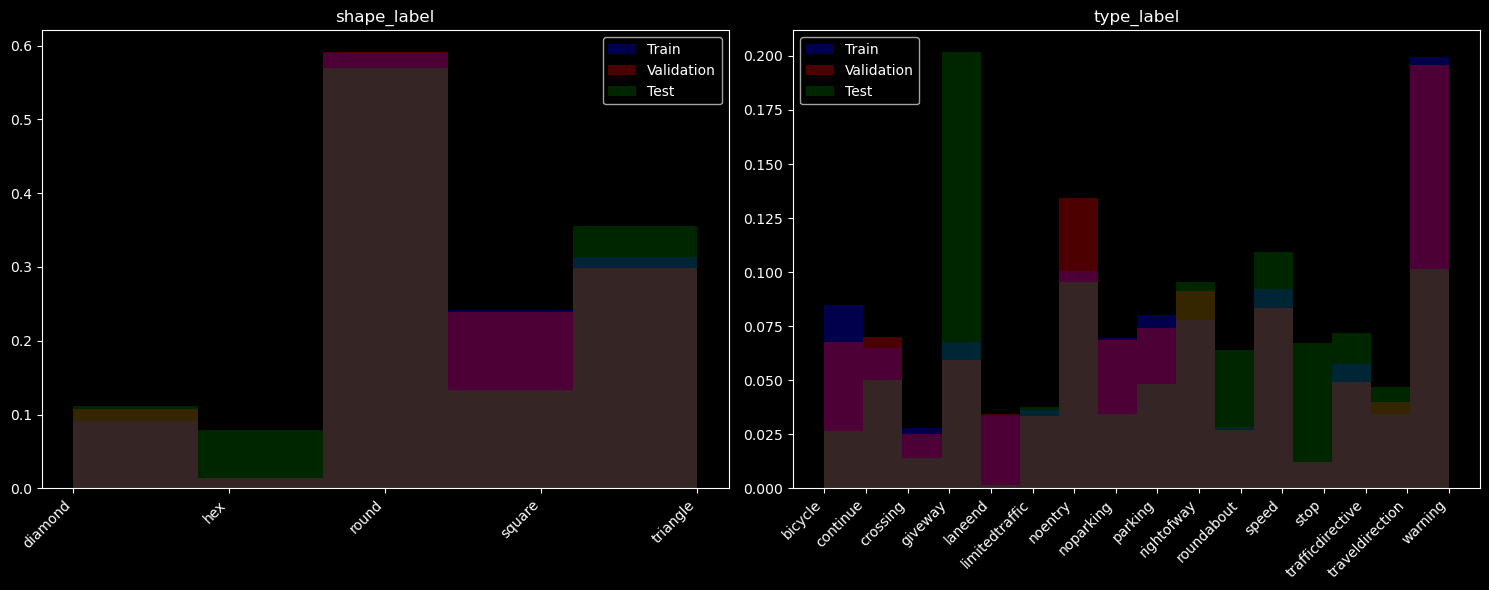

In [14]:
test_dataset_path = 'independent_dataset'

# Create lists to store the image paths, shapes, and types for the test dataset
test_image_paths = []
test_shapes = []
test_types = []

for shape in os.listdir(test_dataset_path):
    shape_path = os.path.join(test_dataset_path, shape)
    for sign_type in os.listdir(shape_path):
        type_path = os.path.join(shape_path, sign_type)
        for image_file in os.listdir(type_path):
            image_path = os.path.join(type_path, image_file)
            test_image_paths.append(image_path)
            test_shapes.append(shape)
            test_types.append(sign_type)

# Encode the shape and type labels for the test dataset
test_shape_labels = shape_encoder.transform(test_shapes)
test_type_labels = type_encoder.transform(test_types)

# Create a DataFrame with image paths, shape labels, and type labels for the test dataset
test_df = pd.DataFrame({
    'image_path': test_image_paths,
    'shape_label': test_shape_labels,
    'type_label': test_type_labels
})

# Print the number of items in the test dataset
print("Number of images in the test set:", len(test_df))

# Create a data generator for the test dataset
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Update the histogram plotting code to include the test dataset
plt.figure(figsize=(15, 6))
for i, col in enumerate(['shape_label', 'type_label']):
    plt.subplot(1, 2, i+1)
    if col == 'shape_label':
        unique_values = shape_labels
    else:
        unique_values = type_labels
    plt.hist(df.loc[train_indices, col], alpha=0.3, color='b', density=True,
             bins=len(unique_values), label='Train')
    plt.hist(df.loc[val_indices, col], alpha=0.3, color='r', density=True,
             bins=len(unique_values), label='Validation')
    plt.hist(test_df[col], alpha=0.3, color='g', density=True,
             bins=len(unique_values), label='Test')
    plt.title(col)
    plt.xticks(range(len(unique_values)), unique_values, rotation=45, ha='right')
    plt.legend()

plt.tight_layout()
plt.show()

In [110]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

## only for transfer
# img_size = (32, 32)
# normal
img_size = (28, 28)

# Initialize empty lists to store the true labels and predicted labels
shape_true_labels = []
type_true_labels = []
shape_pred_labels = []
type_pred_labels = []

# Specify the number of batches to process
num_batches = len(test_df) // 32  # Process all batches in the test dataset

# Create a generator for the test data
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col=None,
    target_size=img_size,
    batch_size=32,
    shuffle=False,
    class_mode=None
)

# Iterate over the test data in batches
batch_count = 0
for batch_data in test_generator:
    # Generate predictions for the current batch
    batch_preds = model.predict(batch_data)
    shape_preds = np.argmax(batch_preds[0], axis=1)
    type_preds = np.argmax(batch_preds[1], axis=1)

    # Get the corresponding true labels for the current batch
    start_index = test_generator.batch_index * test_generator.batch_size
    end_index = start_index + test_generator.batch_size
    batch_shape_labels = test_df['shape_label'].iloc[start_index:end_index].values
    batch_type_labels = test_df['type_label'].iloc[start_index:end_index].values

    # Append the true labels and predicted labels to the lists
    shape_true_labels.extend(batch_shape_labels)
    type_true_labels.extend(batch_type_labels)
    shape_pred_labels.extend(shape_preds)
    type_pred_labels.extend(type_preds)

    batch_count += 1
    if batch_count >= num_batches:
        break  # Exit the loop after processing all batches in the test dataset

# Ensure the lengths of true and predicted labels are the same
min_length = min(len(shape_true_labels), len(shape_pred_labels))
shape_true_labels = shape_true_labels[:min_length]
shape_pred_labels = shape_pred_labels[:min_length]
type_true_labels = type_true_labels[:min_length]
type_pred_labels = type_pred_labels[:min_length]

# Map the predicted labels back to their original names
shape_labels_map = {i: label for i, label in enumerate(shape_encoder.classes_)}
type_labels_map = {i: label for i, label in enumerate(type_encoder.classes_)}

# Create confusion matrices for shape and type
shape_cm = confusion_matrix(shape_true_labels, shape_pred_labels)
type_cm = confusion_matrix(type_true_labels, type_pred_labels)

print("Confusion matrices created.")

# Generate classification report for shape
print("Classification Report - Shape:")
print(classification_report(shape_true_labels, shape_pred_labels, target_names=shape_encoder.classes_))

# Generate classification report for type
print("Classification Report - Type:")
print(classification_report(type_true_labels, type_pred_labels, target_names=type_encoder.classes_))

# Plot the confusion matrix for shape
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(shape_cm, display_labels=shape_encoder.classes_).plot()
plt.title("Shape Confusion Matrix")
plt.xlabel("Predicted Shape")
plt.ylabel("True Shape")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Plot the confusion matrix for type
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(type_cm, display_labels=type_encoder.classes_).plot()
plt.title("Type Confusion Matrix")
plt.xlabel("Predicted Type")
plt.ylabel("True Type")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Found 682 validated image filenames.
1/1 [==============================] - 0s 45ms/step


ValueError: Mix of label input types (string and number)

1/1 [==============================] - 0s 28ms/step


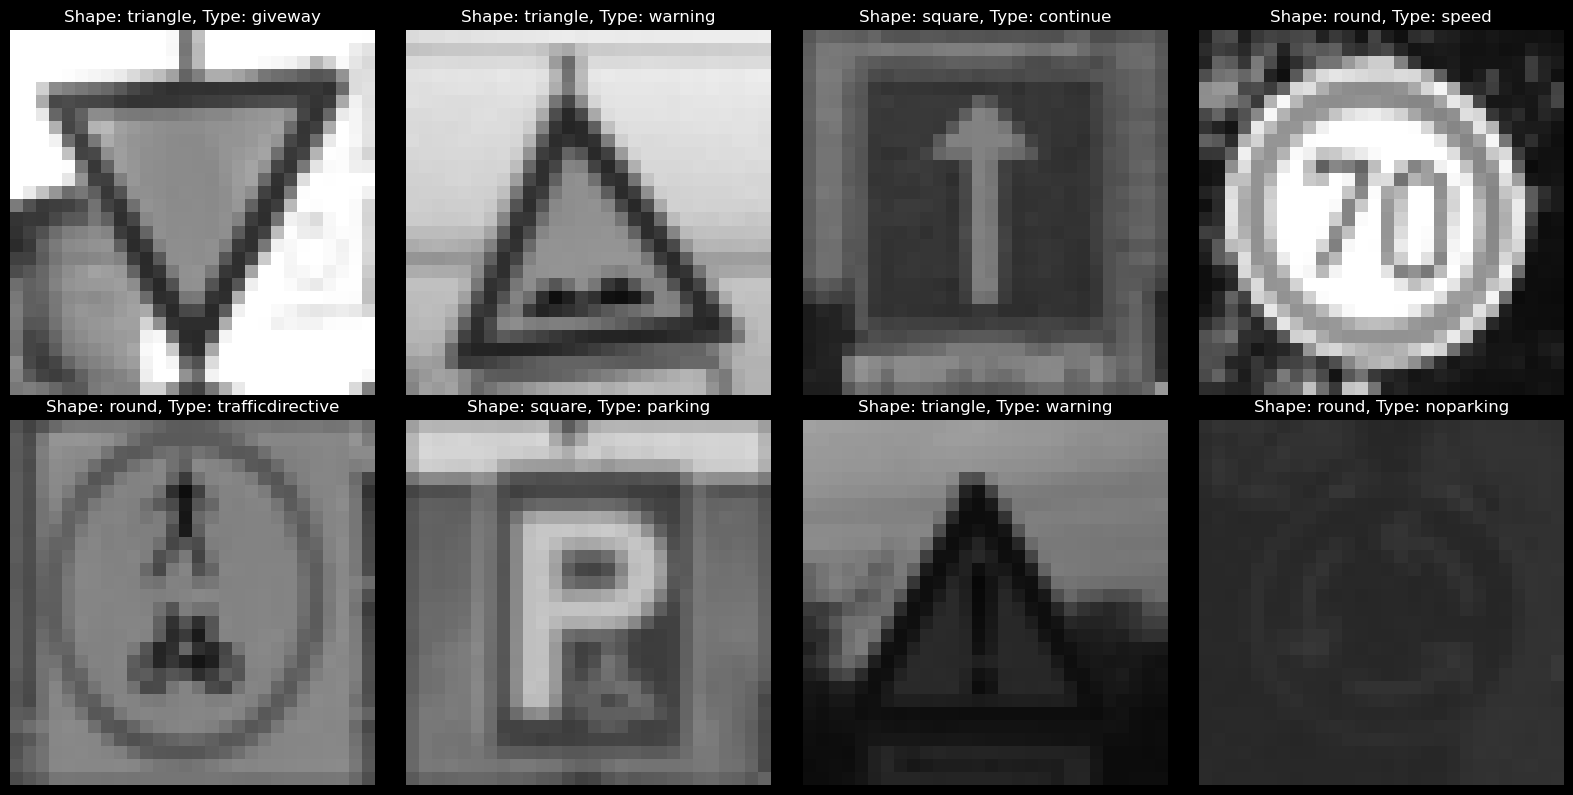

In [218]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 2 rows and 4 columns
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

# Loop through 8 random examples
for i in range(8):
    # Select a random image path from the test set
    random_index = np.random.choice(len(test_df))
    image_path = test_df.iloc[random_index]['image_path']
    
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Make predictions
    preds = model.predict(x)
    shape_pred = preds[0]
    type_pred = preds[1]
    
    # Get the predicted shape and type labels
    shape_label = shape_encoder.inverse_transform([np.argmax(shape_pred)])[0]
    type_label = type_encoder.inverse_transform([np.argmax(type_pred)])[0]
    
    # Display the tested image
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Shape: {shape_label}, Type: {type_label}")

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 52ms/step


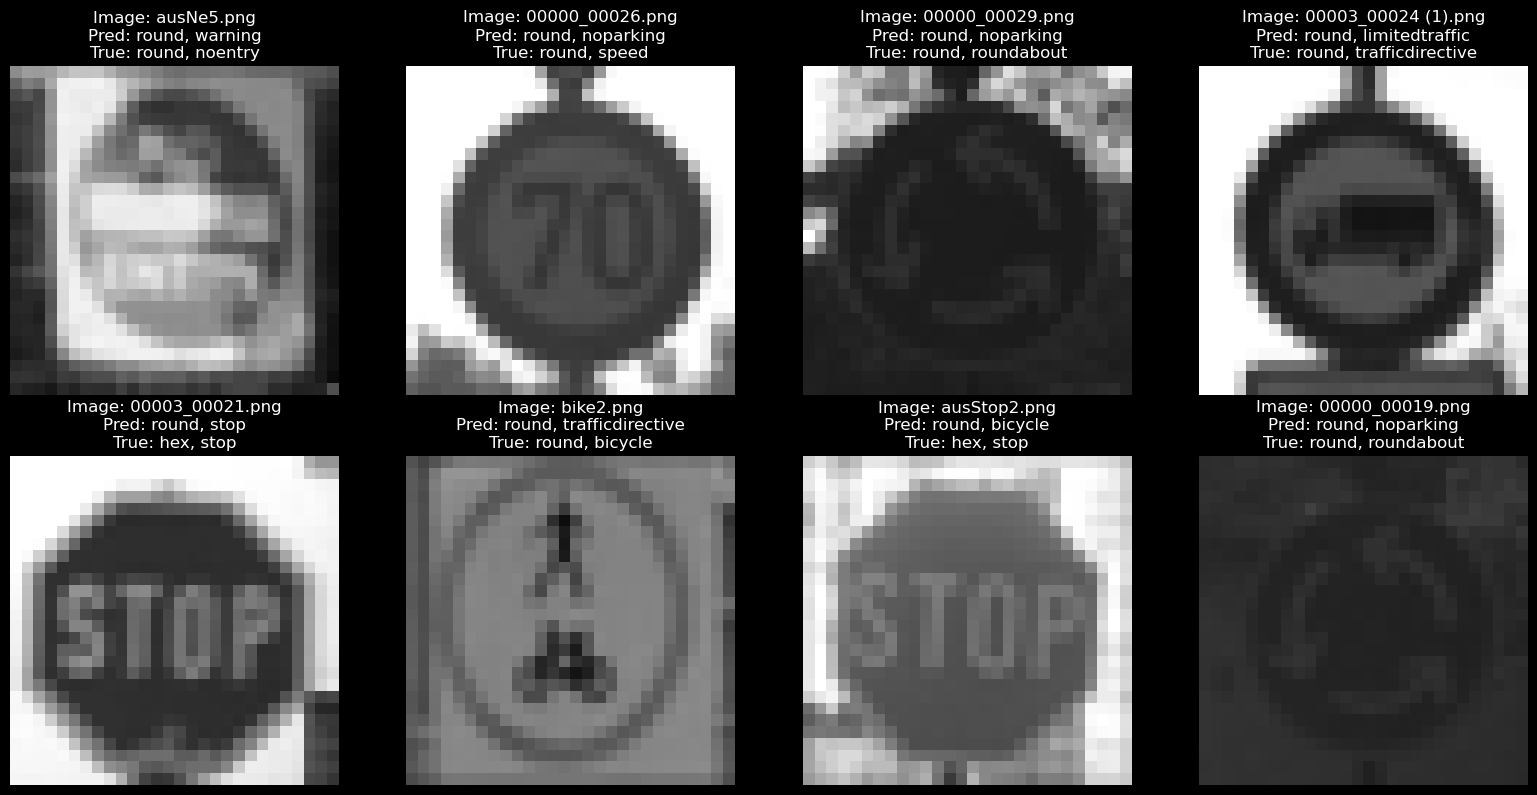

In [219]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

# Create a figure with 2 rows and 4 columns
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

# Initialize a counter for wrongly classified images
wrong_counter = 0

# Loop until we find 8 wrongly classified images
while wrong_counter < 8:
    # Select a random image path from the test set
    random_index = np.random.choice(len(test_df))
    image_path = test_df.iloc[random_index]['image_path']
    
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Make predictions
    preds = model.predict(x)
    shape_pred = preds[0]
    type_pred = preds[1]
    
    # Get the predicted shape and type labels
    shape_label = shape_encoder.inverse_transform([np.argmax(shape_pred)])[0]
    type_label = type_encoder.inverse_transform([np.argmax(type_pred)])[0]
    
    # Get the true shape and type labels
    true_shape_label = shape_encoder.inverse_transform([test_df.iloc[random_index]['shape_label']])[0]
    true_type_label = type_encoder.inverse_transform([test_df.iloc[random_index]['type_label']])[0]
    
    # Check if the predicted labels match the true labels
    if shape_label != true_shape_label or type_label != true_type_label:
        # Extract the image name from the image path
        image_name = os.path.basename(image_path)
        
        # Display the wrongly classified image with the image name
        axes[wrong_counter].imshow(img)
        axes[wrong_counter].axis('off')
        axes[wrong_counter].set_title(f"Image: {image_name}\nPred: {shape_label}, {type_label}\nTrue: {true_shape_label}, {true_type_label}")
        wrong_counter += 1

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 54ms/step


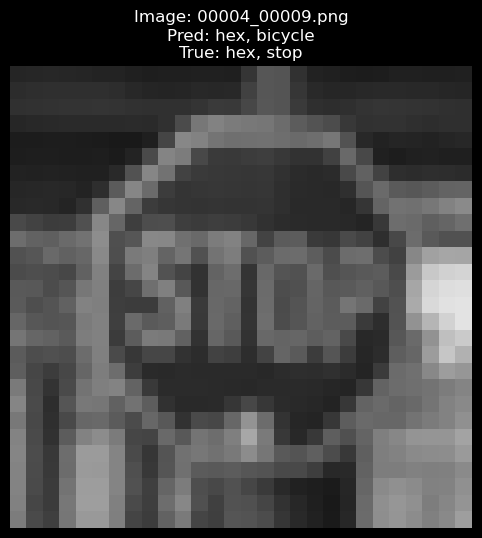

1/1 [==============================] - 0s 18ms/step


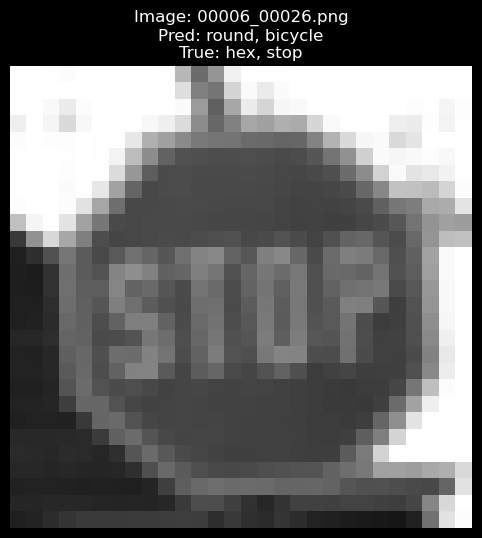

1/1 [==============================] - 0s 51ms/step


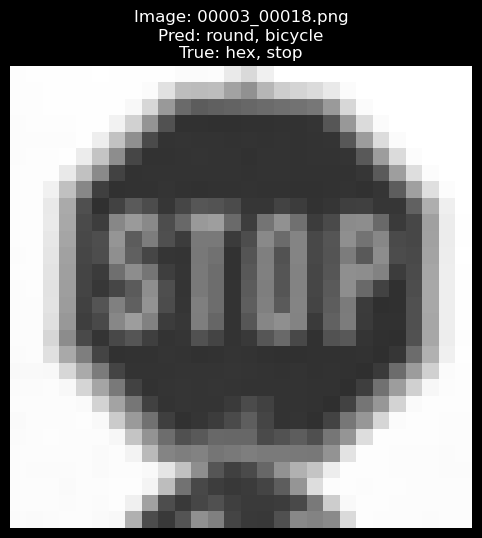

1/1 [==============================] - 0s 28ms/step


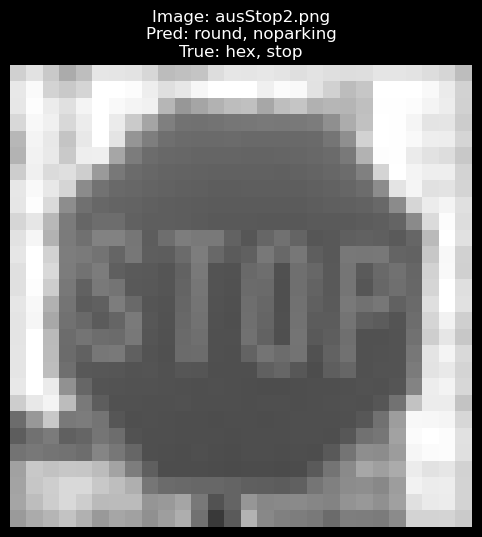

1/1 [==============================] - 0s 49ms/step


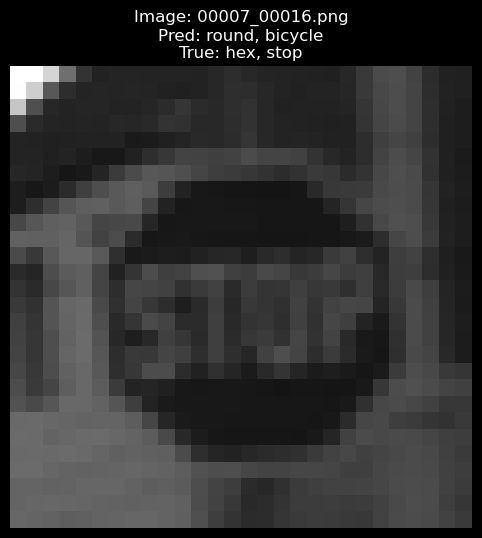

1/1 [==============================] - 0s 17ms/step


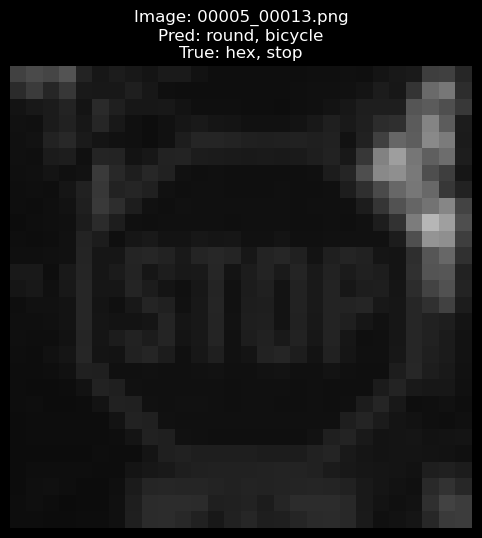

1/1 [==============================] - 0s 54ms/step


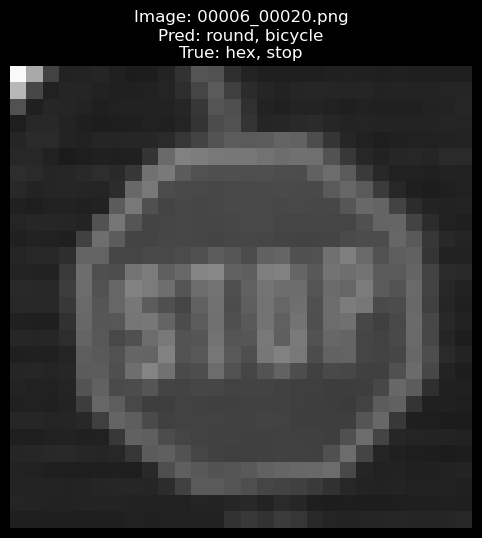

1/1 [==============================] - 0s 76ms/step


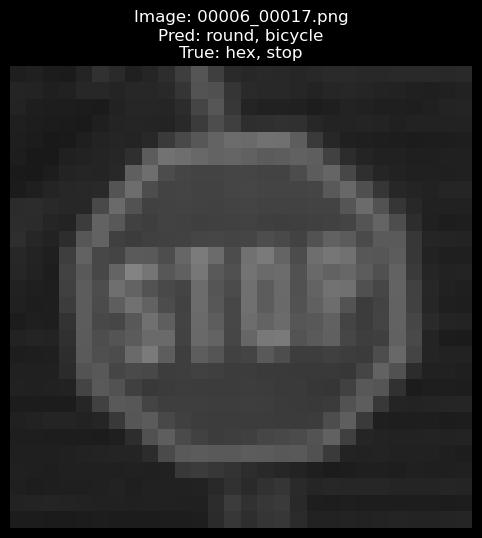

1/1 [==============================] - 0s 76ms/step


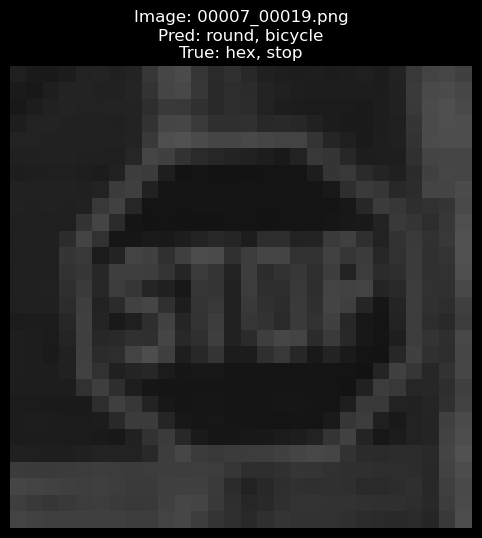

1/1 [==============================] - 0s 53ms/step


FileNotFoundError: [Errno 2] No such file or directory: 'independent_dataset/diamond/rightofway/00000_00025.png'

In [195]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to display all misclassified images based on type
def display_misclassified_images(model, test_df, shape_encoder, type_encoder, img_size=(224, 224)):
    # Loop through the test set
    for i in range(len(test_df)):
        image_path = test_df.iloc[i]['image_path']
        true_shape_label = shape_encoder.inverse_transform([test_df.iloc[i]['shape_label']])[0]
        true_type_label = type_encoder.inverse_transform([test_df.iloc[i]['type_label']])[0]

        # Load and preprocess the image
        img = image.load_img(image_path, target_size=img_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # Make predictions
        preds = model.predict(x)
        shape_pred = preds[0]
        type_pred = preds[1]

        # Get the predicted shape and type labels
        shape_label = shape_encoder.inverse_transform([np.argmax(shape_pred)])[0]
        type_label = type_encoder.inverse_transform([np.argmax(type_pred)])[0]

        # Check if the predicted type label does not match the true type label
        if type_label != true_type_label:
            # Extract the image name from the image path
            image_name = os.path.basename(image_path)

            # Display the misclassified image with the image name
            plt.figure(figsize=(8, 6))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Image: {image_name}\nPred: {shape_label}, {type_label}\nTrue: {true_shape_label}, {true_type_label}")
            plt.show()

# Example usage
display_misclassified_images(model, test_df, shape_encoder, type_encoder, img_size=(28, 28))

In [ ]:
Comparing to non neural network models

Confusion matrices created.
Classification Report - Shape:
              precision    recall  f1-score   support

     diamond       0.71      0.25      0.37        61
         hex       0.00      0.00      0.00        43
       round       0.67      0.95      0.78       311
      square       0.58      0.53      0.56        73
    triangle       0.88      0.67      0.76       194

    accuracy                           0.70       682
   macro avg       0.57      0.48      0.49       682
weighted avg       0.68      0.70      0.67       682

Classification Report - Type:
                  precision    recall  f1-score   support

         bicycle       0.13      0.53      0.21        17
        continue       0.83      0.78      0.81        32
        crossing       0.00      0.00      0.00         9
         giveway       0.94      0.58      0.72       129
         laneend       1.00      1.00      1.00         1
  limitedtraffic       0.46      0.54      0.50        24
         noentr

<Figure size 800x600 with 0 Axes>

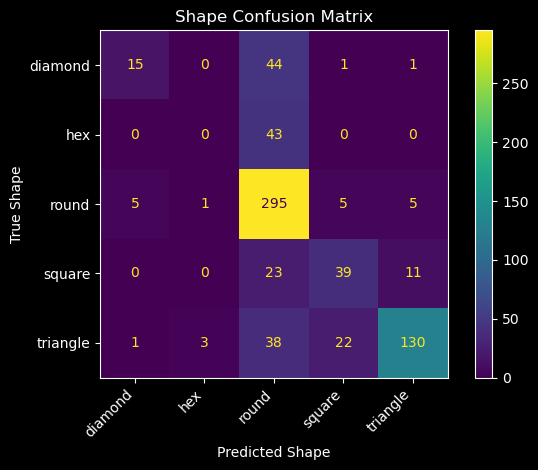

<Figure size 800x600 with 0 Axes>

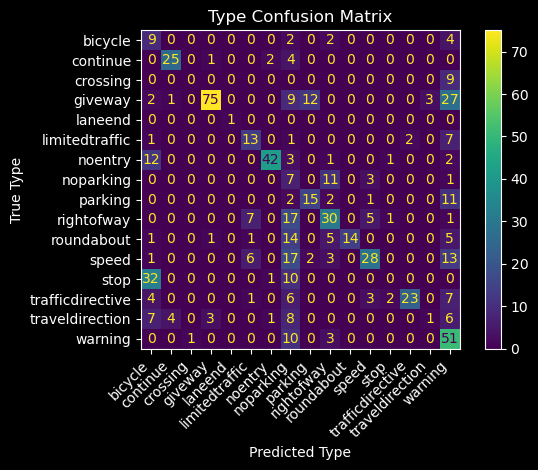

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Initialize empty lists to store the true labels and predicted labels
shape_true_labels = []
type_true_labels = []
shape_pred_labels = []
type_pred_labels = []

# Load and preprocess the test images
test_images = []
for image_path in test_df['image_path']:
    img = imageio.imread(image_path)
    img = img / 255.0
    test_images.append(img.flatten())

test_images = np.array(test_images)

# Get the true labels for the test images
test_shape_labels = test_df['shape_label'].values
test_type_labels = test_df['type_label'].values

# Generate predictions using the trained Random Forest classifiers
# change test_x to df for random forest, dt for decision tree, and gb for gradient boosted.
shape_preds = shape_gb_best.predict(test_images)
type_preds = type_gb_best.predict(test_images)

# Append the true labels and predicted labels to the lists
shape_true_labels.extend(test_shape_labels)
type_true_labels.extend(test_type_labels)
shape_pred_labels.extend(shape_preds)
type_pred_labels.extend(type_preds)

# Map the predicted labels back to their original names
shape_labels_map = {i: label for i, label in enumerate(shape_encoder.classes_)}
type_labels_map = {i: label for i, label in enumerate(type_encoder.classes_)}

# Create confusion matrices for shape and type
shape_cm = confusion_matrix(shape_true_labels, shape_pred_labels)
type_cm = confusion_matrix(type_true_labels, type_pred_labels)

print("Confusion matrices created.")

# Generate classification report for shape
print("Classification Report - Shape:")
print(classification_report(shape_true_labels, shape_pred_labels, target_names=shape_encoder.classes_))

# Generate classification report for type
print("Classification Report - Type:")
print(classification_report(type_true_labels, type_pred_labels, target_names=type_encoder.classes_))

# Plot the confusion matrix for shape
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(shape_cm, display_labels=shape_encoder.classes_).plot()
plt.title("Shape Confusion Matrix")
plt.xlabel("Predicted Shape")
plt.ylabel("True Shape")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Plot the confusion matrix for type
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(type_cm, display_labels=type_encoder.classes_).plot()
plt.title("Type Confusion Matrix")
plt.xlabel("Predicted Type")
plt.ylabel("True Type")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt
import imageio

# Initialize empty lists to store the true labels and predicted labels
shape_true_labels = []
type_true_labels = []
shape_pred_labels = []
type_pred_labels = []

# Load and preprocess the test images
test_images = []
for image_path in test_df['image_path']:
    img = imageio.imread(image_path)
    img = img / 255.0
    test_images.append(img.flatten())

test_images = np.array(test_images)

# Get the true labels for the test images
test_shape_labels = test_df['shape_label'].values
test_type_labels = test_df['type_label'].values

# Generate predictions using the trained logistic regression classifiers
shape_preds = shape_classifier.predict(test_images)
type_preds = type_classifier.predict(test_images)

# Append the true labels and predicted labels to the lists
shape_true_labels.extend(test_shape_labels)
type_true_labels.extend(test_type_labels)
shape_pred_labels.extend(shape_preds)
type_pred_labels.extend(type_preds)

# Map the predicted labels back to their original names
shape_labels_map = {i: label for i, label in enumerate(shape_encoder.classes_)}
type_labels_map = {i: label for i, label in enumerate(type_encoder.classes_)}

# Create confusion matrices for shape and type
shape_cm = confusion_matrix(shape_true_labels, shape_pred_labels)
type_cm = confusion_matrix(type_true_labels, type_pred_labels)

print("Confusion matrices created.")

# Generate classification report for shape
print("Classification Report - Shape:")
print(classification_report(shape_true_labels, shape_pred_labels, target_names=shape_encoder.classes_))

# Generate classification report for type
print("Classification Report - Type:")
print(classification_report(type_true_labels, type_pred_labels, target_names=type_encoder.classes_))

# Plot the confusion matrix for shape
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(shape_cm, display_labels=shape_encoder.classes_).plot()
plt.title("Shape Confusion Matrix")
plt.xlabel("Predicted Shape")
plt.ylabel("True Shape")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Plot the confusion matrix for type
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(type_cm, display_labels=type_encoder.classes_).plot()
plt.title("Type Confusion Matrix")
plt.xlabel("Predicted Type")
plt.ylabel("True Type")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

NameError: name 'y_train' is not defined

In [44]:
# Transfer Learning

In [63]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df.iloc[train_indices],
    x_col='image_path',
    y_col=['shape_label', 'type_label'],
    target_size=(32, 32),  # Resize to (32, 32)
    batch_size=32,
    class_mode='multi_output'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df.iloc[val_indices],
    x_col='image_path',
    y_col=['shape_label', 'type_label'],
    target_size=(32, 32),  # Resize to (32, 32)
    batch_size=32,
    class_mode='multi_output'
)

Found 2959 validated image filenames.
Found 740 validated image filenames.


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(28, 28, 3))

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(28, 28, 3))

In [46]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(28, 28, 3))

NameError: name 'ResNet50' is not defined

In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(28, 28, 3))

In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(28, 28, 3))

In [ ]:
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(28, 28, 3))

In [64]:
from keras.applications import VGG16
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

from keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create the model architecture
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)

# Output layers for shape and type
shape_output = Dense(num_shape_classes, activation='softmax', name='shape')(x)
type_output = Dense(num_type_classes, activation='softmax', name='type')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=[shape_output, type_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'shape': 'sparse_categorical_crossentropy',
                    'type': 'sparse_categorical_crossentropy'},
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_indices) // 32,
    validation_data=val_generator,
    validation_steps=np.ceil(len(val_indices) / 32).astype(int),
    epochs=20
)

Epoch 1/20


2024-05-10 19:05:20.614936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - ETA: 0s - loss: 3.5324 - shape_loss: 1.0647 - type_loss: 2.2975 - shape_accuracy: 0.5938 - type_accuracy: 0.3092

2024-05-10 19:05:29.010539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - 10s 90ms/step - loss: 3.5324 - shape_loss: 1.0647 - type_loss: 2.2975 - shape_accuracy: 0.5938 - type_accuracy: 0.3092 - val_loss: 2.8346 - val_shape_loss: 0.8645 - val_type_loss: 1.9164 - val_shape_accuracy: 0.6514 - val_type_accuracy: 0.4216
Epoch 2/20
92/92 [==============================] - 7s 78ms/step - loss: 2.6238 - shape_loss: 0.7828 - type_loss: 1.7779 - shape_accuracy: 0.6891 - type_accuracy: 0.4561 - val_loss: 2.4431 - val_shape_loss: 0.7449 - val_type_loss: 1.6255 - val_shape_accuracy: 0.7216 - val_type_accuracy: 0.5054
Epoch 3/20
92/92 [==============================] - 7s 75ms/step - loss: 2.3943 - shape_loss: 0.7168 - type_loss: 1.5950 - shape_accuracy: 0.7123 - type_accuracy: 0.5056 - val_loss: 2.3400 - val_shape_loss: 0.7159 - val_type_loss: 1.5335 - val_shape_accuracy: 0.7176 - val_type_accuracy: 0.5216
Epoch 4/20
92/92 [==============================] - 7s 77ms/step - loss: 2.2815 - shape_loss: 0.6830 - type_loss: 1.5012 - sh

In [ ]:
# Unsupervised

In [ ]:
K-Means

In [47]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.image import load_img, img_to_array

# Function to load and preprocess images
def load_and_preprocess_image(path):
    img = load_img(path, target_size=(28, 28))
    img_array = img_to_array(img)
    img_array = img_array.flatten()
    return img_array

# Load and preprocess the images
image_paths = df['image_path'].values
X = np.array([load_and_preprocess_image(path) for path in image_paths])

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Specify the number of clusters (k)
k = 5

# Create and fit the k-means model
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)

# Get the cluster labels for each image
labels = kmeans.labels_

# Print the cluster labels
print("Cluster Labels:")
print(labels)

ImportError: cannot import name 'load_img' from 'keras.preprocessing.image' (/opt/anaconda/lib/python3.11/site-packages/keras/preprocessing/image.py)